# Actual Exploratory Data Analysis

In [1]:
import os
os.chdir('../../scripts')
import pandas as pd
import matplotlib.pyplot as plt
from post_processing import get_output
from analysis_tools_cython import *
import seaborn as sns

## Functions

In [2]:
def plot_lc(data):
    for i in data.path:
        lc, lc_info = import_XRPlightcurve(i,sector=6)
        lc = lc['time','corrected flux','quality','flux error']
        results, _ = processing(lc,'.',lc_info=lc_info,method='median',make_plots=True)

In [3]:
data = get_output('../output_log/s6_new.txt')
print(len(data))
data_copy = data.copy()
data = data[data.transit_prob == 'maybeTransit']
print(len(data), "after maybeTransit")
data.head()

624281
339700 after maybeTransit


path         id     signal  \
11  /tmp/tess/tesslcs_sector_6_104/tesslcs_tmag_10...  176727936  -7.527300   
12  /tmp/tess/tesslcs_sector_6_104/2_min_cadence_t...  322900369 -13.786212   
13  /tmp/tess/tesslcs_sector_6_104/tesslcs_tmag_10...  161635683  -7.719857   
14  /tmp/tess/tesslcs_sector_6_104/tesslcs_tmag_11...  200611535 -18.619789   
15  /tmp/tess/tesslcs_sector_6_104/tesslcs_tmag_10...  263802490  -4.934514   

          snr         time  asym_score    width1    width2  duration  \
11  -5.624174  1476.370382    1.000008  0.127236  0.000306  0.374995   
12  -6.601620  1484.494492    1.400345  0.102817  0.000967  0.125001   
13  -3.443742  1486.950086    1.000002  0.052427  0.000118  0.583321   
14 -10.749594  1473.204059    1.000000  0.005650  0.000727  0.166664   
15  -4.374506  1488.349758    1.000000  0.089806  0.000273  0.104167   

       depth  peak_lspower  mstat  skewness  skewness_err   m    n  chisquare  \
11 -0.001024      0.057352  0.084 -0.487098  7.852315e+00  18  353 -13.543560   
12 -0.006429      0.111895  0.646  3.713266  9.727259e-01   6  743  -6.434390   
13 -0.000952      0.068937  0.010 -0.478866  2.071115e+01  28  859 -74.522759   
14 -0.012965      0.026624  0.389 -0.010161  3.317408e+07   8  201 -14.979960   
15 -0.001212      0.020107  0.022 -0.007619  2.679863e+04   5  928 -29.452239   

    transit_prob  
11  maybeTransit  
12  maybeTransit  
13  maybeTransit  
14  maybeTransit  
15  maybeTransit

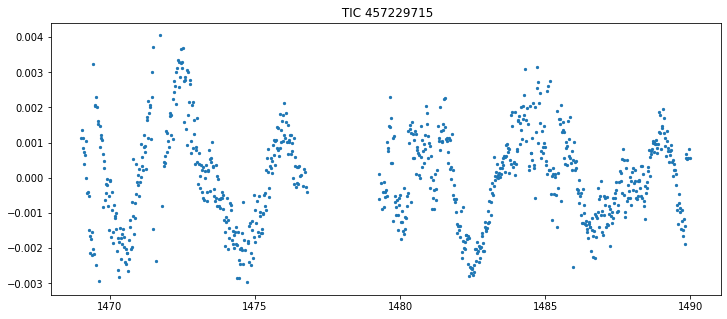

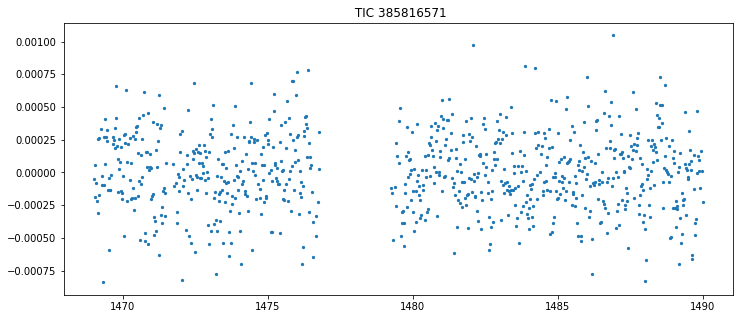

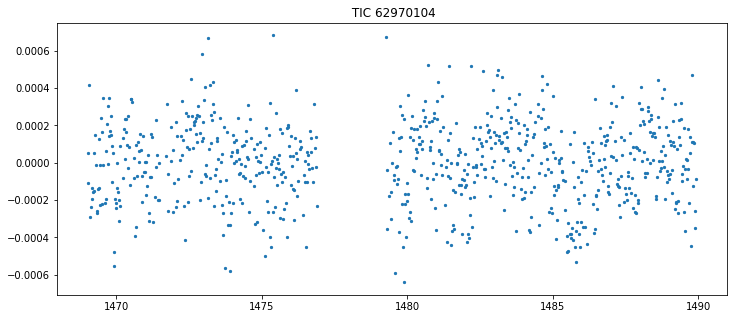

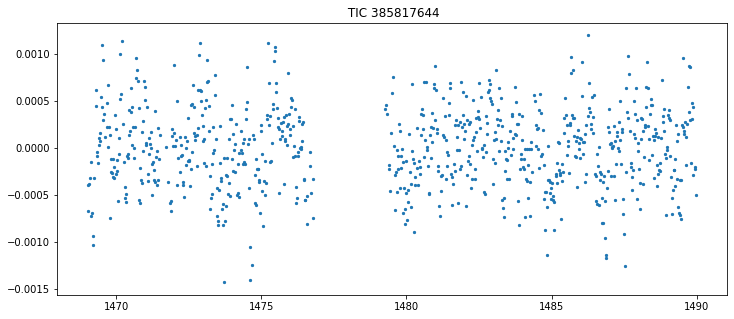

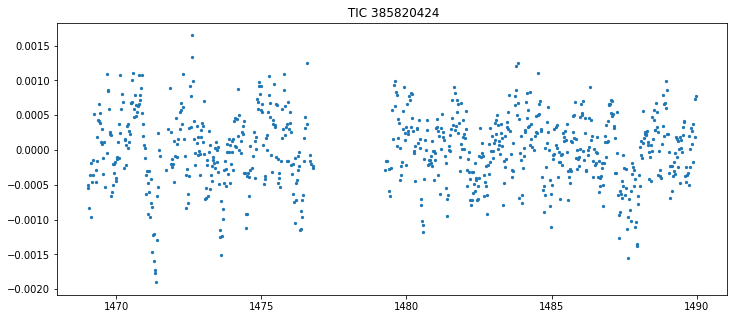

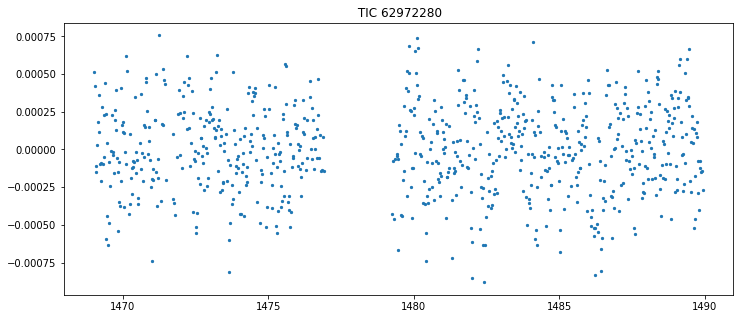

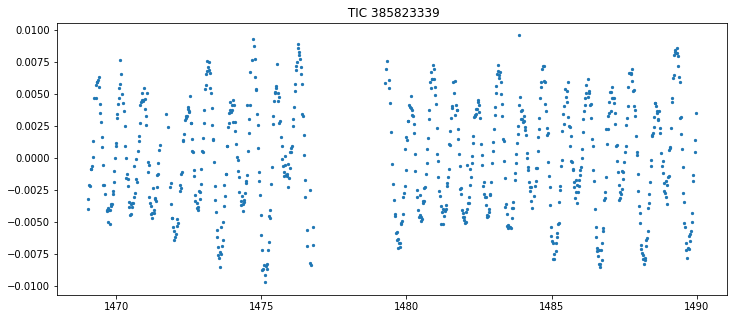

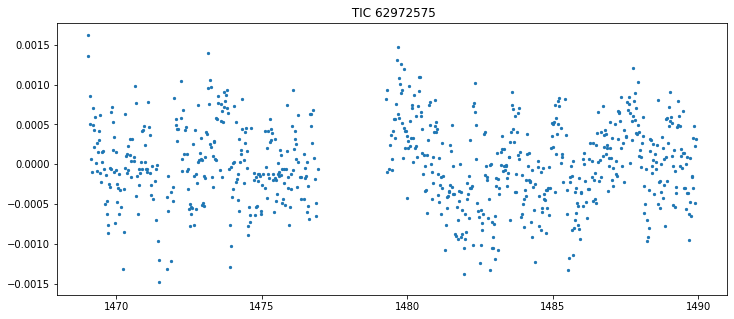

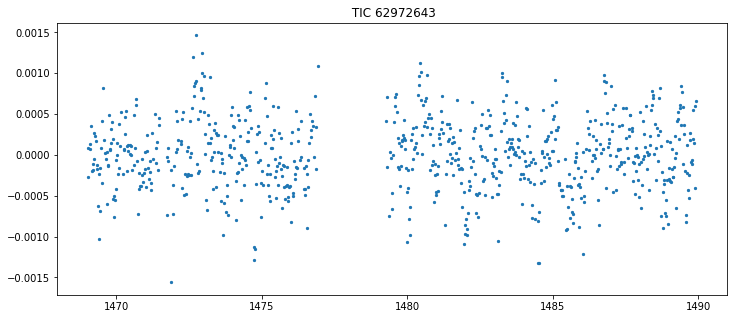

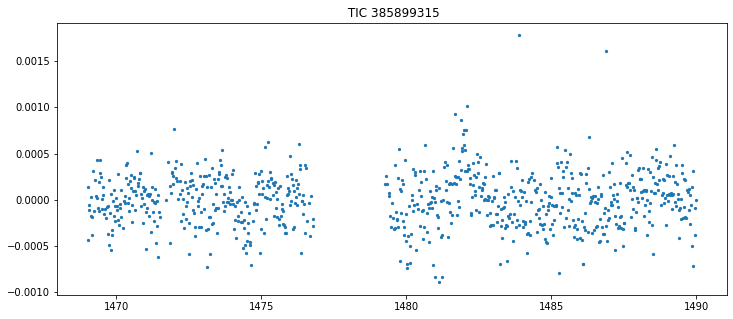

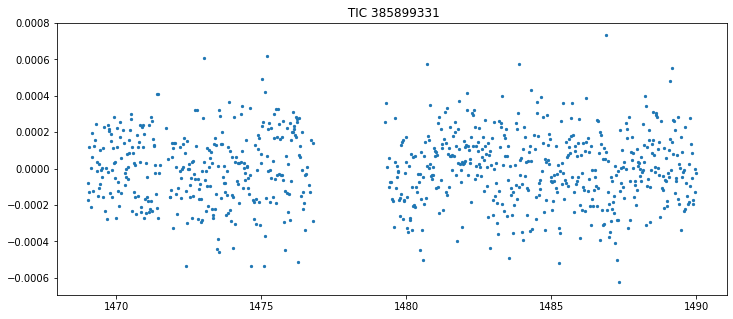

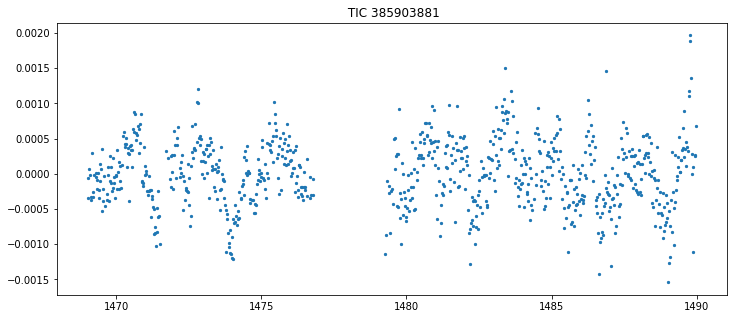

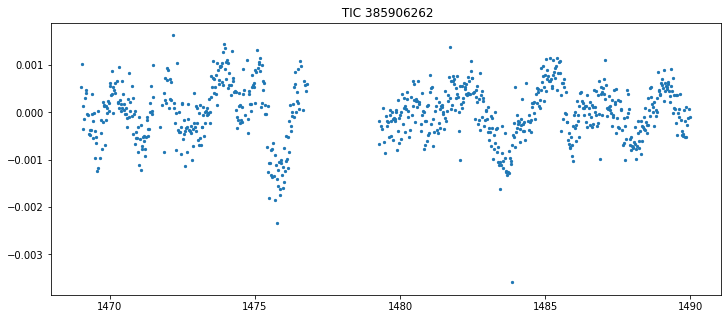

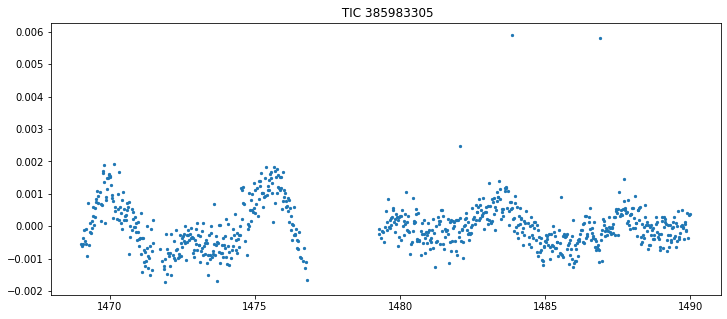

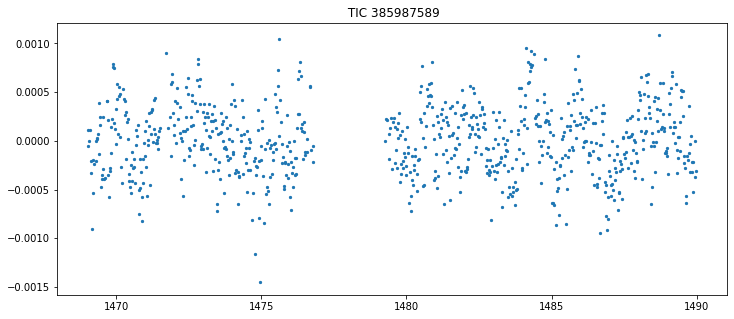

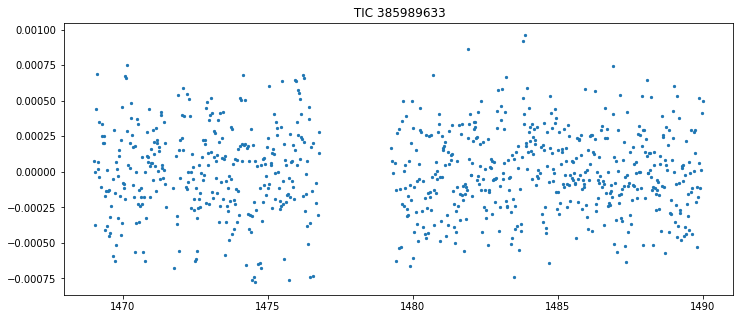

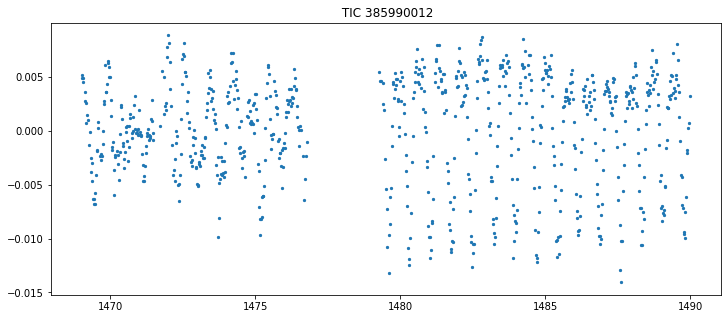

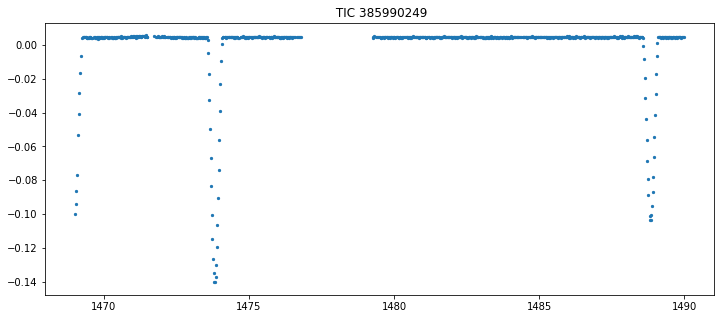

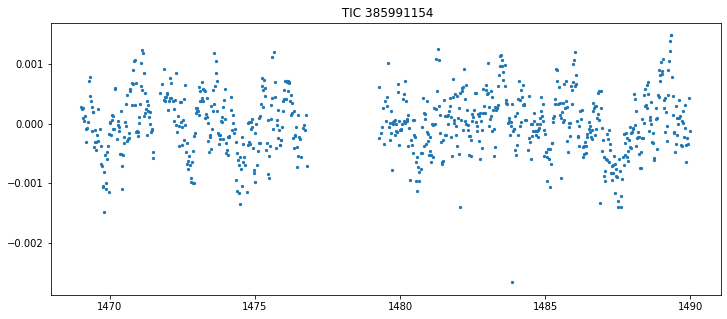

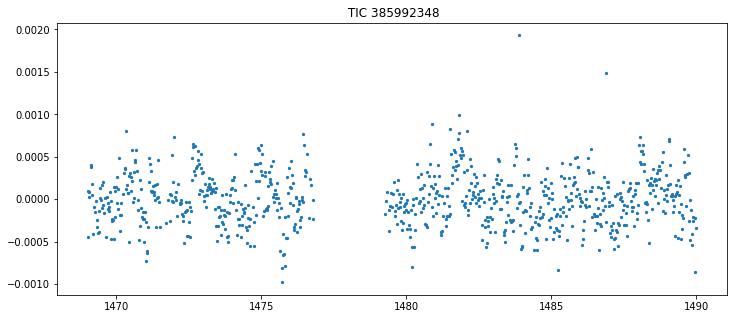

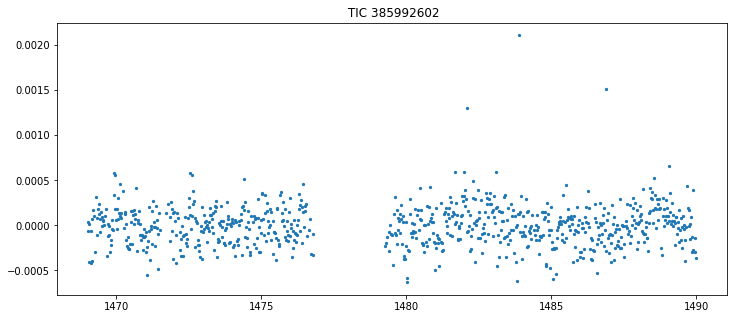

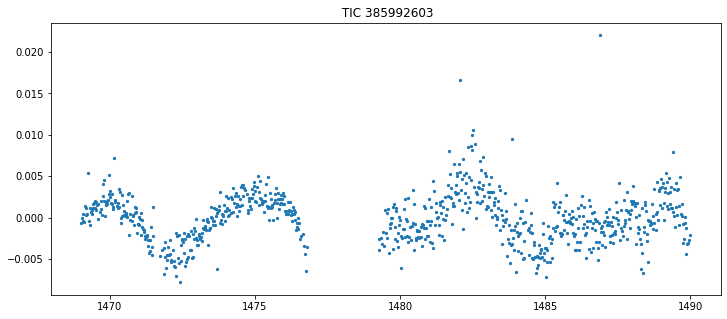

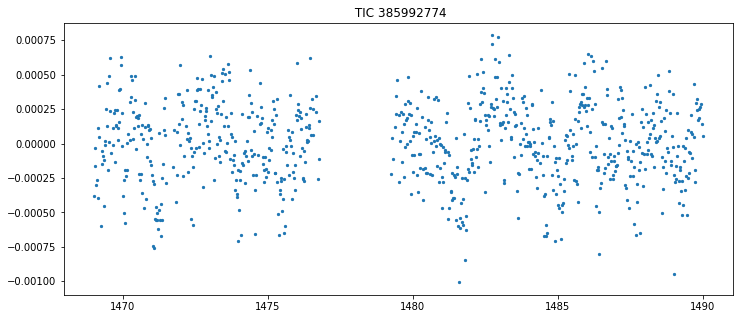

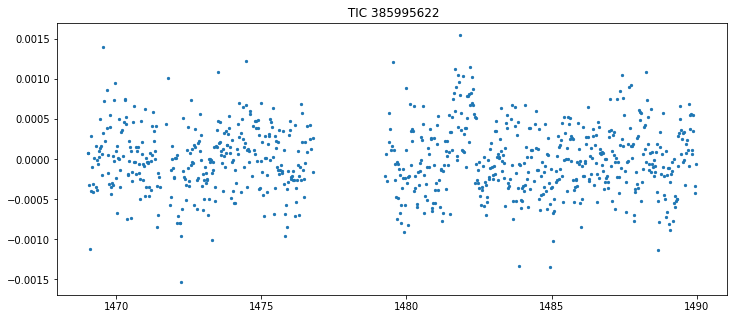

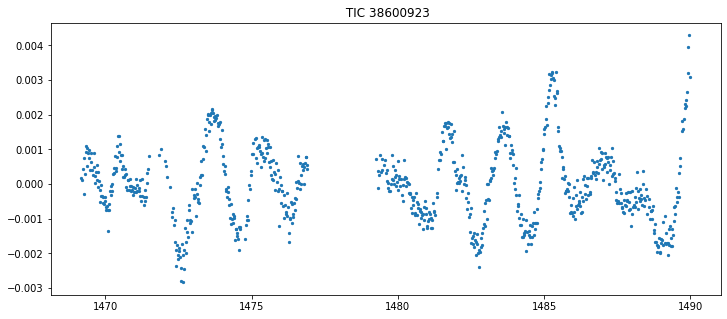

In [4]:
for i in data.path.tail(25): #4 x 4 grid for illustration purposes
    lc, lc_info = import_XRPlightcurve(i,sector=6)
    plt.figure(figsize=(12,5))
    plt.scatter(lc['time'],normalise_flux(lc['corrected flux']), s=5)
    plt.title(f' TIC {lc_info[0]}')
    plt.show()


## Removing bad data
From early plots, we know that there is a fair amount of bad data. This includes:
- Lightcurves with mysterious large dips that occur in the space of ~5-10 cadences that do not show up in any other lightcurve pipeline (includeing direct `eleanor` lightcurves. 
- Models fitted on the data have ridiculous skewness values.
We will remove these from the dataset.

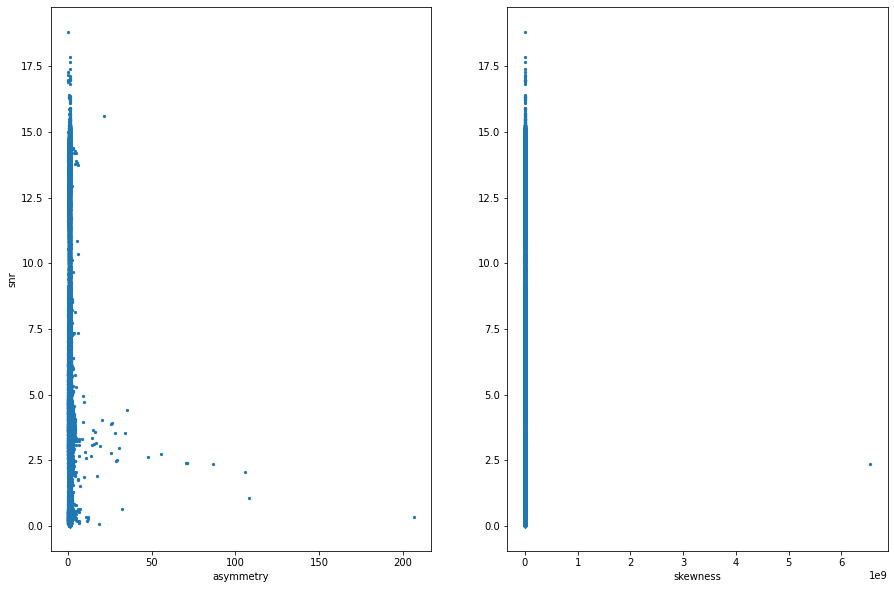

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,10))
ax[0].scatter(data.asym_score,abs(data.snr),s=5)
ax[0].set_xlabel("asymmetry")
ax[1].set_xlabel("skewness")
ax[0].set_ylabel("snr")
ax[1].scatter(data.skewness,abs(data.snr),s=5)
plt.show()

In [6]:
data = data[(data.asym_score <= 10) & (data.skewness >= -100) & (data.skewness <= 100)].reset_index(drop=True)

### Scatterplot after removing most aggressive outliers

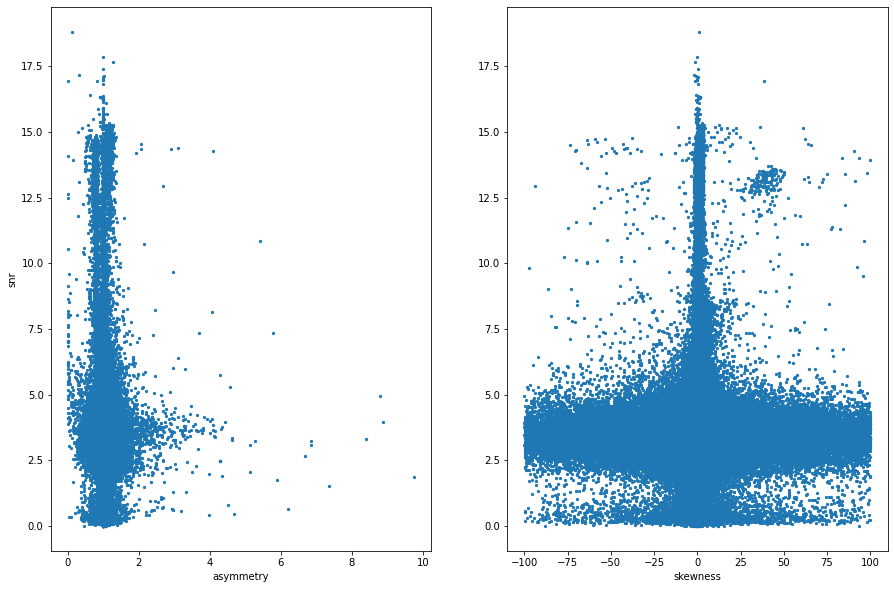

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,10))
ax[0].scatter(data.asym_score,abs(data.snr),s=5)
ax[0].set_xlabel("asymmetry")
ax[1].set_xlabel("skewness")
ax[0].set_ylabel("snr")
ax[1].scatter(data.skewness,abs(data.snr),s=5)
plt.show()

### Histograms of time and duration
- We know there are bad lightcurves in the XRP batch

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f84d04ee310>]],
      dtype=object)

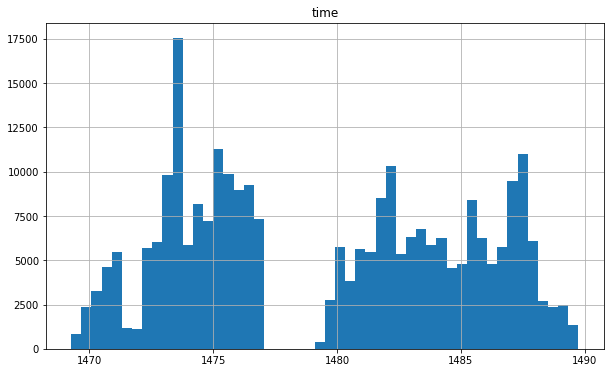

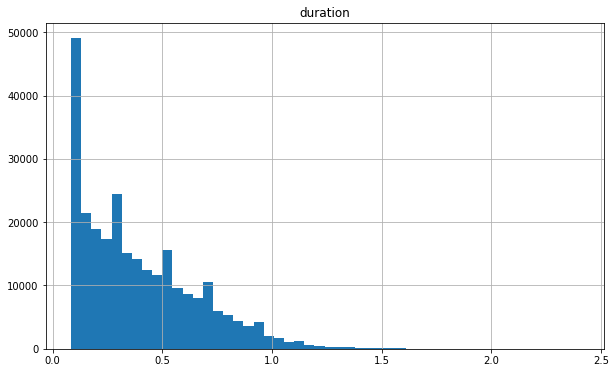

In [8]:
data.hist('time',bins=50,figsize=(10,6))
data.hist('duration',bins=50,figsize=(10,6))


### Do the spikes on these histograms happen at a specific time?

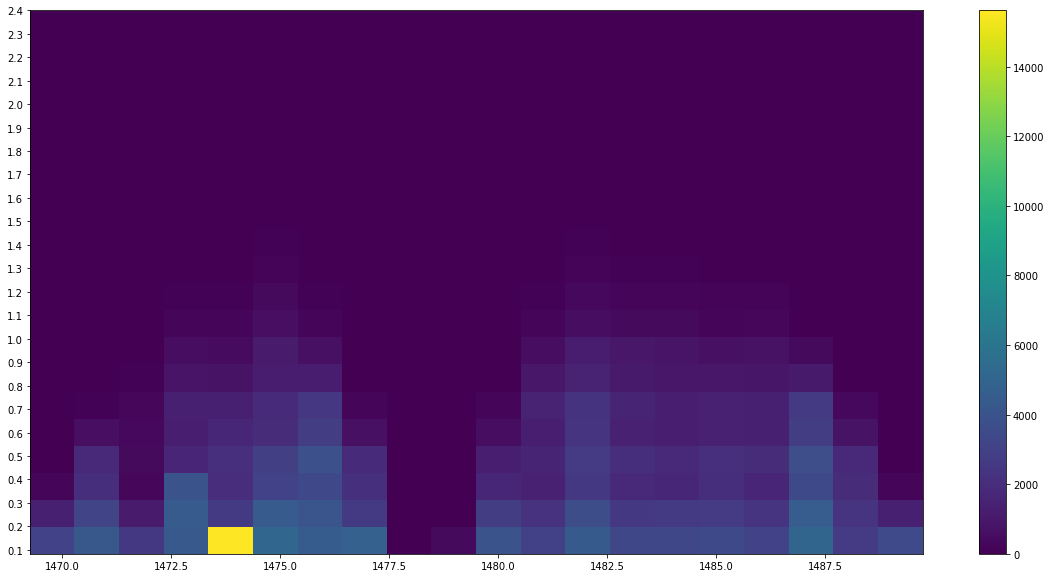

In [9]:
plt.figure(figsize=(20,10))
plt.hist2d(data['time'], data['duration'], bins=[20, 20])
plt.yticks(ticks=np.arange(0.1,2.5,0.1))
plt.colorbar()
plt.show()

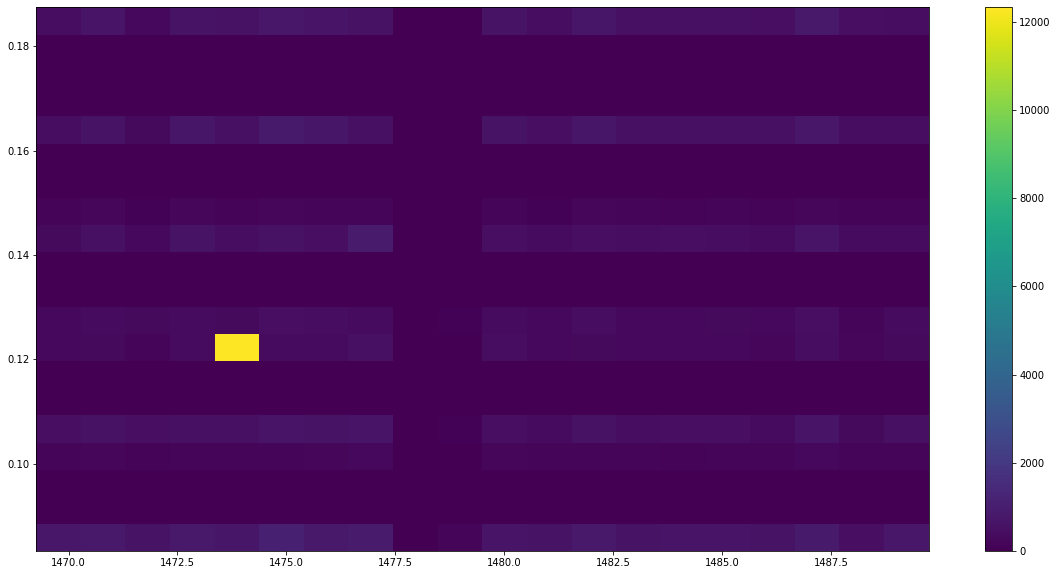

In [10]:
plt.figure(figsize=(20,10))
plt.hist2d(data['time'][data.duration <= 0.2], data['duration'][data.duration <= 0.2], bins=[20, 20])
plt.colorbar()
plt.show()

Yes, they do.

#### Let's zoom in to that time range where there is a spike at 1473, and re-plot

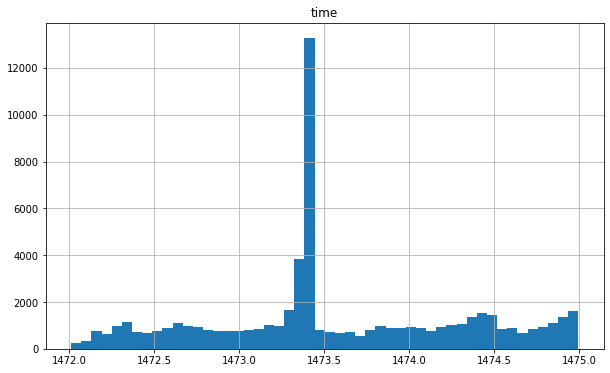

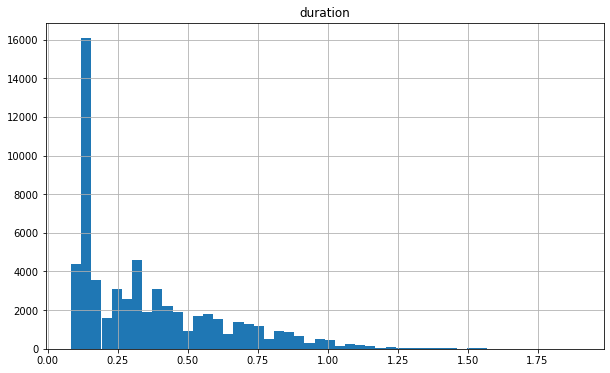

In [11]:
data.loc[(data.time >=1472) & (data.time <= 1475)].hist('time',bins=50,figsize=(10,6))
data.loc[(data.time >=1472) & (data.time <= 1475)].hist('duration',bins=50,figsize=(10,6))
plt.show()

From some analysis of the clusters in the above skewness plots, we find that the failed lightcurves have a property of `duraion ~ 0.125` and `time = 1473.433` so we drop all lightcurves in that range.

**Drop this data**

In [12]:
to_cut = data[(data['duration'] <= 0.125) & (data['time'] >= 1473.433) & (data['time'] <= 1473.5)].reset_index(drop=True)
len(to_cut)

12136

In [13]:
to_cut

path         id  \
0      /tmp/tess/tesslcs_sector_6_104/tesslcs_tmag_11...  247667362   
1      /tmp/tess/tesslcs_sector_6_104/tesslcs_tmag_11...  200611933   
2      /tmp/tess/tesslcs_sector_6_104/tesslcs_tmag_11...  247667783   
3      /tmp/tess/tesslcs_sector_6_104/tesslcs_tmag_11...  200612145   
4      /tmp/tess/tesslcs_sector_6_104/tesslcs_tmag_11...  247668351   
...                                                  ...        ...   
12131  /tmp/tess/tesslcs_sector_6_104/tesslcs_tmag_9_...   97857275   
12132  /tmp/tess/tesslcs_sector_6_104/tesslcs_tmag_9_...   97860218   
12133  /tmp/tess/tesslcs_sector_6_104/tesslcs_tmag_9_...   97963456   
12134  /tmp/tess/tesslcs_sector_6_104/tesslcs_tmag_9_...   97964403   
12135  /tmp/tess/tesslcs_sector_6_104/tesslcs_tmag_9_...   97964624   

          signal        snr         time  asym_score    width1    width2  \
0     -25.110094 -13.396243  1473.433314    0.775375  0.152708  0.058647   
1     -25.170195 -14.430333  1473.433233    0.761306  0.131954  0.005972   
2     -24.859329 -13.119020  1473.433311    0.768544  0.180457  0.010820   
3     -24.103878 -13.903501  1473.433237    0.761174  0.163502  0.005183   
4     -24.707457 -12.957003  1473.433308    0.761379  0.183117  0.033836   
...          ...        ...          ...         ...       ...       ...   
12131 -22.430336 -14.176766  1473.433256    1.151333  0.021908  0.000495   
12132 -24.949682 -13.215327  1473.433281    0.768567  0.152847  0.009500   
12133 -24.135544 -12.569553  1473.433314    0.769522  0.159102  0.023061   
12134 -24.777250 -13.146389  1473.433308    0.767656  0.162073  0.007773   
12135 -21.230730 -12.530801  1473.433306    1.195162  0.019813  0.000697   

       duration     depth  peak_lspower  mstat  skewness  skewness_err  m  \
0      0.124998 -0.153178      0.031529  0.562  0.008028  28184.103427  6   
1      0.124998 -0.018034      0.025337  0.486  0.012132   3081.449336  6   
2      0.124998 -0.027556      0.034732  0.557 -0.782509      2.524677  6   
3      0.124998 -0.015057      0.024734  0.487  0.904659      2.813569  6   
4      0.124998 -0.085738      0.033733  0.580  0.821546      2.433138  6   
...         ...       ...           ...    ...       ...           ... ..   
12131  0.124999 -0.010884      0.032895  0.361  2.821410     41.002175  6   
12132  0.124999 -0.024771      0.033770  0.537  0.018724   9980.773653  6   
12133  0.124999 -0.057759      0.036048  0.500 -0.011374   5262.001180  6   
12134  0.124999 -0.019730      0.033325  0.556  0.331517      9.927977  6   
12135  0.124999 -0.015660      0.053875  0.252  2.517582     47.123604  6   

         n   chisquare  transit_prob  
0      212 -140.114240  maybeTransit  
1      212  -18.806233  maybeTransit  
2      212  -24.767437  maybeTransit  
3      212  -14.808228  maybeTransit  
4      212  -75.514838  maybeTransit  
...    ...         ...           ...  
12131  212   -9.952018  maybeTransit  
12132  212  -23.927096  maybeTransit  
12133  212  -61.608982  maybeTransit  
12134  212  -18.356363  maybeTransit  
12135  212  -20.806705  maybeTransit  

[12136 rows x 18 columns]

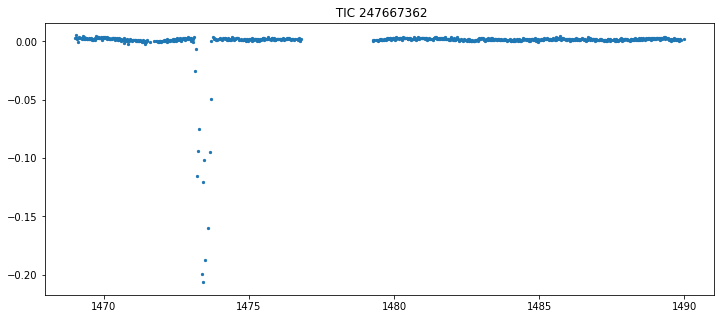

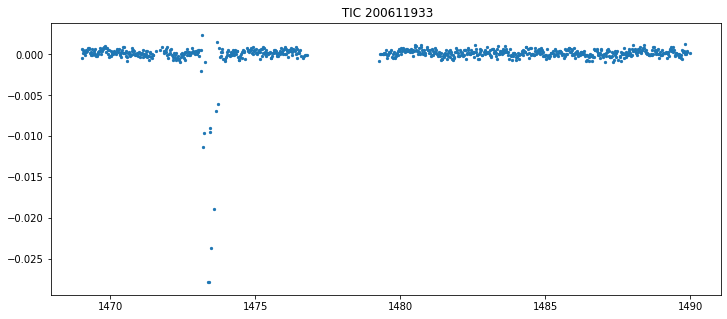

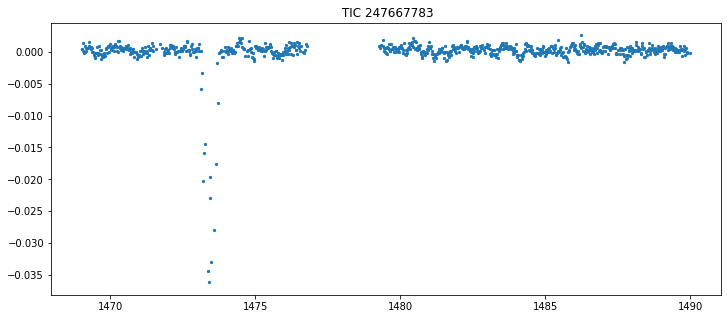

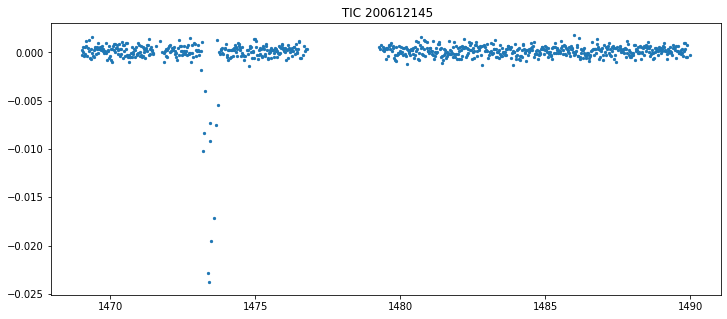

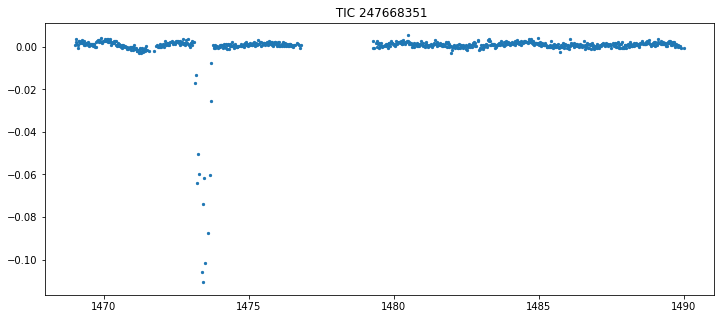

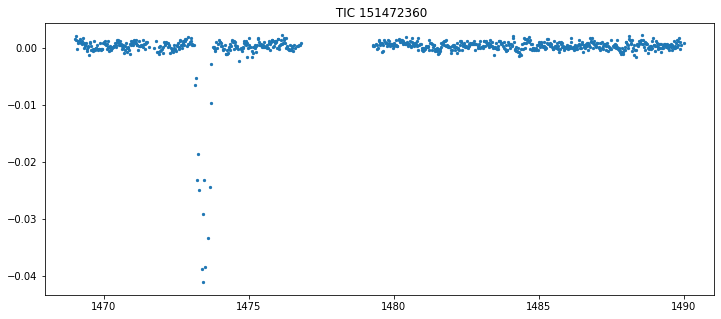

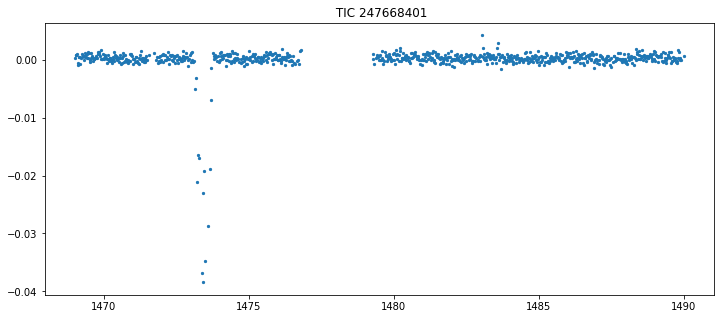

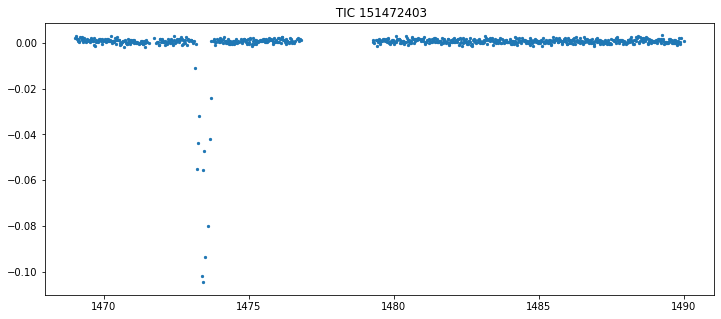

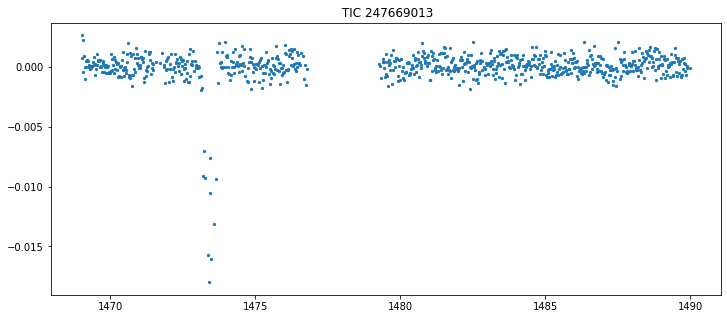

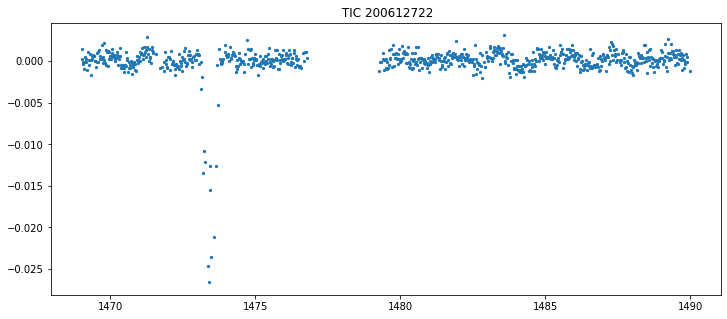

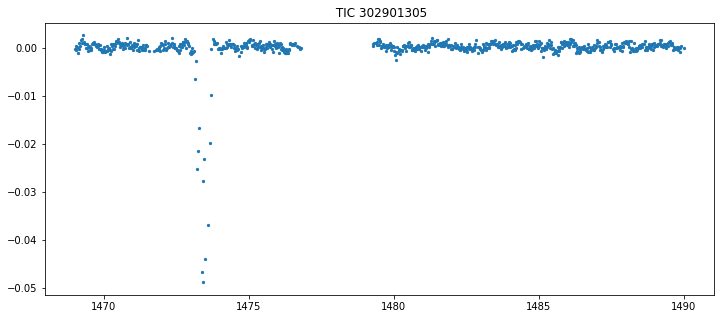

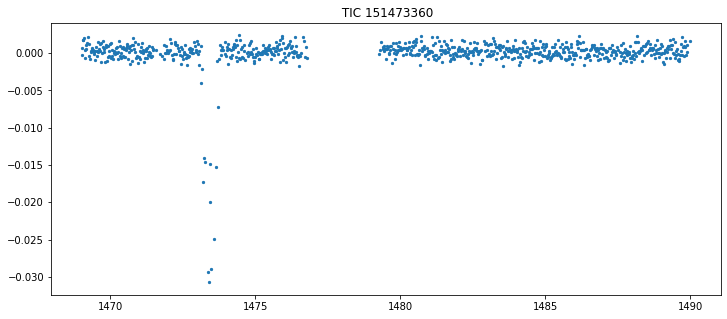

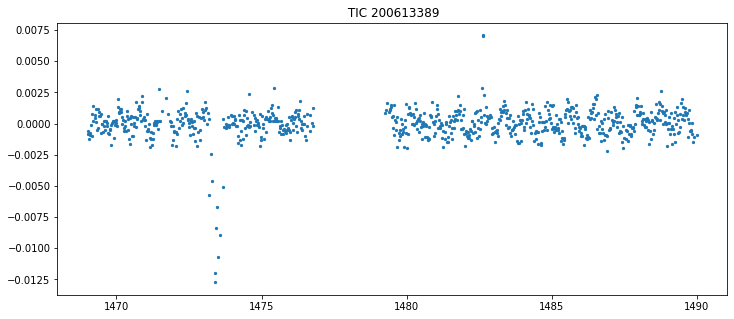

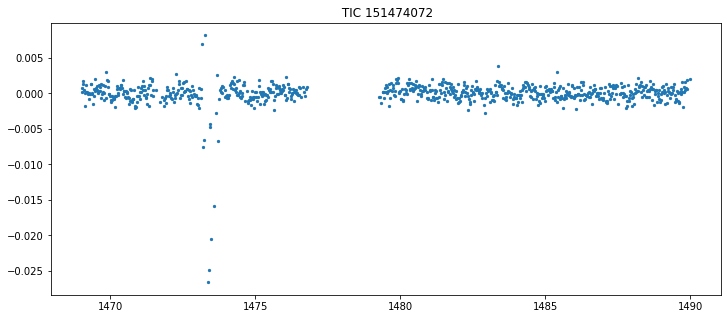

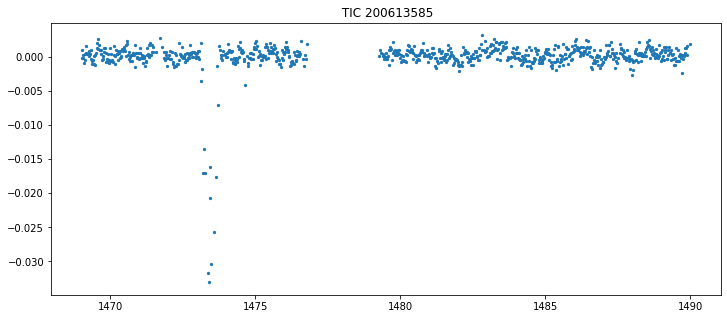

In [14]:
for i in to_cut.path.head(15): #4 x 4 grid for illustration purposes
    lc, lc_info = import_XRPlightcurve(i,sector=6)
    plt.figure(figsize=(12,5))
    plt.scatter(lc['time'],normalise_flux(lc['corrected flux']), s=5)
    plt.title(f' TIC {lc_info[0]}')
    plt.show()

In [15]:
data.drop(data[(data['duration'] <= 0.125) & (data['time'] >= 1473.433) & (data['time'] <= 1473.434)].index,inplace=True)
data.head()

path         id     signal  \
0  /tmp/tess/tesslcs_sector_6_104/tesslcs_tmag_10...  176727936  -7.527300   
1  /tmp/tess/tesslcs_sector_6_104/2_min_cadence_t...  322900369 -13.786212   
2  /tmp/tess/tesslcs_sector_6_104/tesslcs_tmag_10...  161635683  -7.719857   
3  /tmp/tess/tesslcs_sector_6_104/tesslcs_tmag_11...  200611535 -18.619789   
4  /tmp/tess/tesslcs_sector_6_104/tesslcs_tmag_10...  263802490  -4.934514   

         snr         time  asym_score    width1    width2  duration     depth  \
0  -5.624174  1476.370382    1.000008  0.127236  0.000306  0.374995 -0.001024   
1  -6.601620  1484.494492    1.400345  0.102817  0.000967  0.125001 -0.006429   
2  -3.443742  1486.950086    1.000002  0.052427  0.000118  0.583321 -0.000952   
3 -10.749594  1473.204059    1.000000  0.005650  0.000727  0.166664 -0.012965   
4  -4.374506  1488.349758    1.000000  0.089806  0.000273  0.104167 -0.001212   

   peak_lspower  mstat  skewness  skewness_err   m    n  chisquare  \
0      0.057352  0.084 -0.487098  7.852315e+00  18  353 -13.543560   
1      0.111895  0.646  3.713266  9.727259e-01   6  743  -6.434390   
2      0.068937  0.010 -0.478866  2.071115e+01  28  859 -74.522759   
3      0.026624  0.389 -0.010161  3.317408e+07   8  201 -14.979960   
4      0.020107  0.022 -0.007619  2.679863e+04   5  928 -29.452239   

   transit_prob  
0  maybeTransit  
1  maybeTransit  
2  maybeTransit  
3  maybeTransit  
4  maybeTransit

### Scatterplot after cleaning this

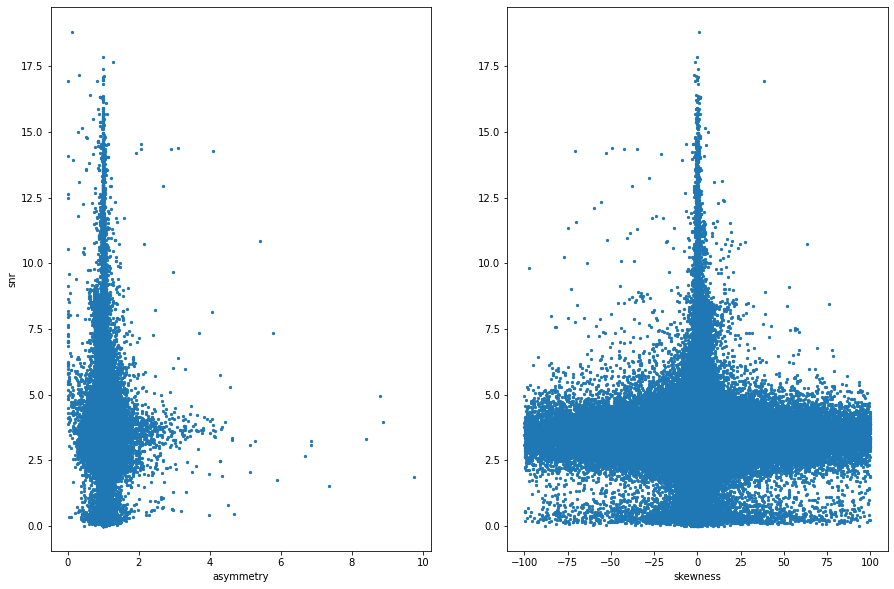

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,10))
ax[0].scatter(data.asym_score,abs(data.snr),s=5)
ax[0].set_xlabel("asymmetry")
ax[1].set_xlabel("skewness")
ax[0].set_ylabel("snr")
ax[1].scatter(data.skewness,abs(data.snr),s=5)
plt.show()

### Dropping data with high asymmetry scores

In [17]:
data.drop(data[(data['asym_score'] >= 3)].index,inplace=True)

### Scatterplot after removing high asymmetry scores

No handles with labels found to put in legend.


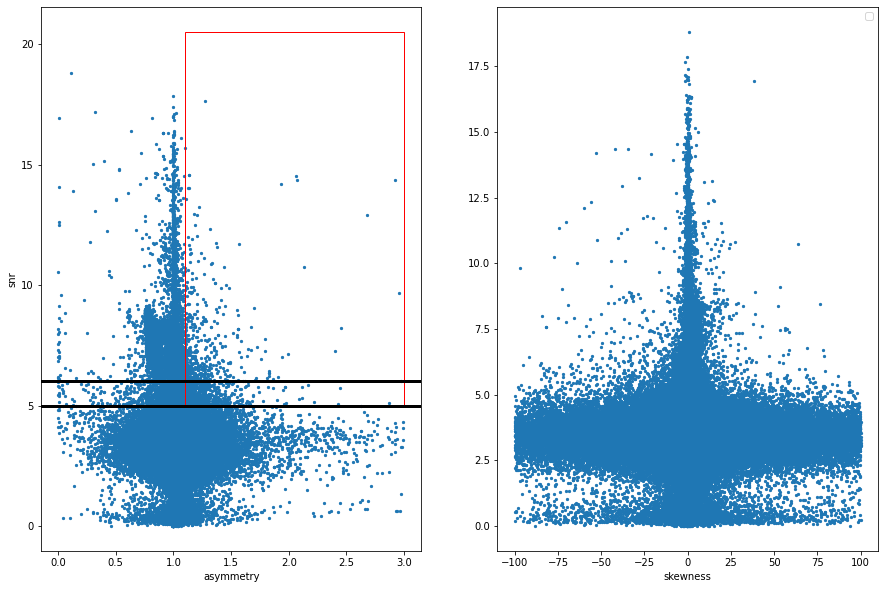

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,10))
ax[0].scatter(data.asym_score,abs(data.snr),s=5)
ax[0].set_xlabel("asymmetry")
ax[1].set_xlabel("skewness")
ax[0].set_ylabel("snr")
ax[1].scatter(data.skewness,abs(data.snr),s=5)
rect = patches.Rectangle((1.1, 5), 1.9, 15.5, linewidth=1, edgecolor='r', facecolor='none',label='Kepler box')
ax[0].add_patch(rect)
ax[0].axhline(y=5,color='black',linewidth=3)
ax[0].axhline(y=6,color='black',linewidth=3)

plt.legend()
plt.show()

---

- I would say the data is now clean from any extreme outliers. More subtle outliers still remain.

## Correlations

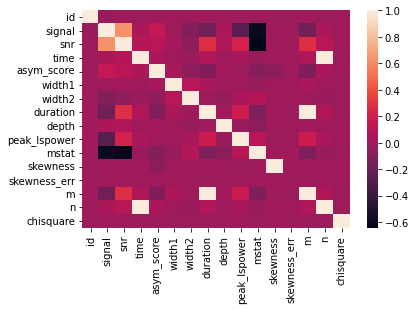

In [19]:
corr = data.corr()
sns.heatmap(corr)

In [20]:
data.snr = abs(data.snr)

### Accept only data with `snr >= 5`

In [21]:
data_new = data[data.snr >= 5].reset_index(drop=True)

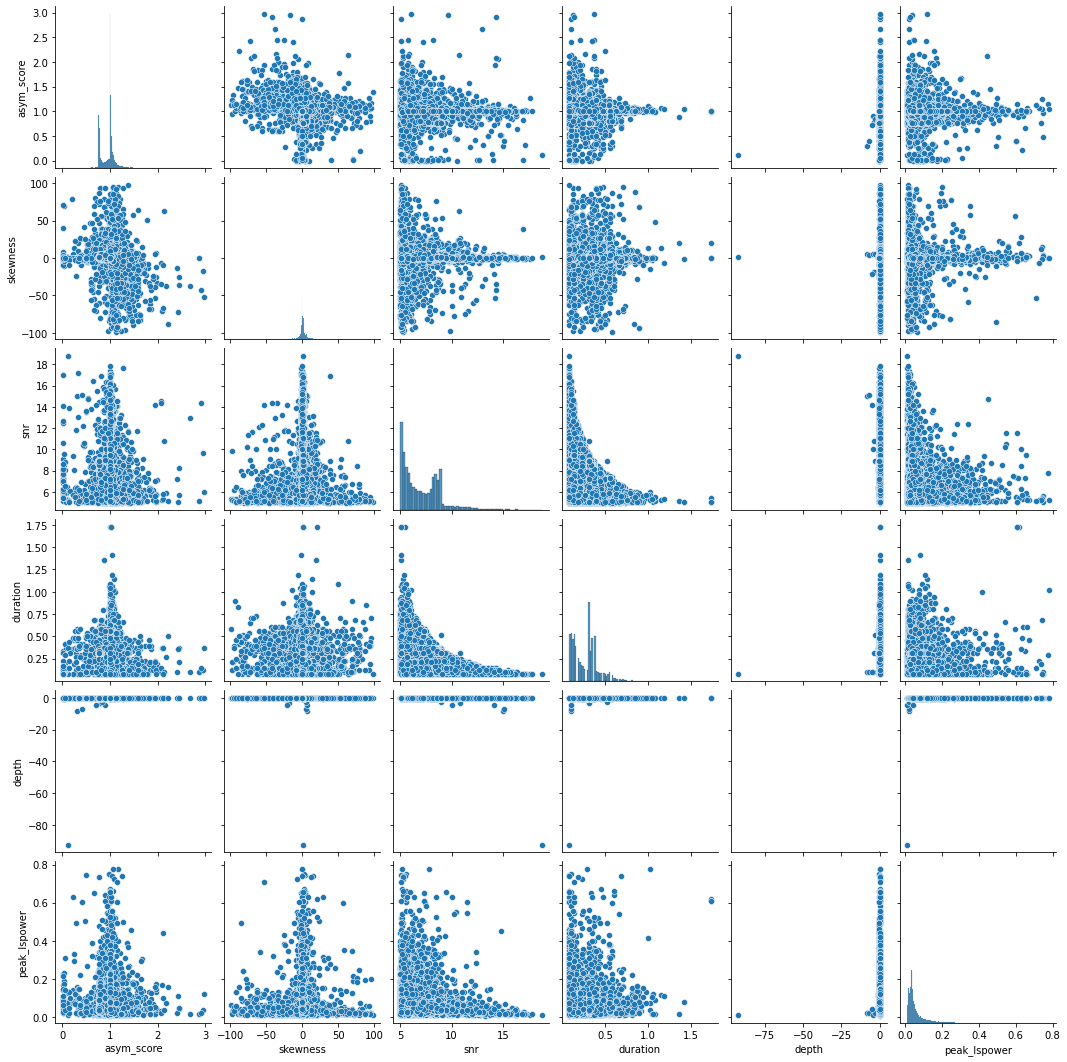

In [22]:
sns.pairplot(data_new,vars=['asym_score','skewness','snr','duration','depth','peak_lspower'])

---

In [23]:
data_new.drop(data_new[(data_new['depth'] <= -1.5)].index,inplace=True)

In [24]:
data_new

path         id  \
0      /tmp/tess/tesslcs_sector_6_104/tesslcs_tmag_10...  176727936   
1      /tmp/tess/tesslcs_sector_6_104/2_min_cadence_t...  322900369   
2      /tmp/tess/tesslcs_sector_6_104/tesslcs_tmag_11...  200611535   
3      /tmp/tess/tesslcs_sector_6_104/tesslcs_tmag_10...  234664465   
4      /tmp/tess/tesslcs_sector_6_104/tesslcs_tmag_11...  156715053   
...                                                  ...        ...   
14212  /tmp/tess/tesslcs_sector_6_104/tesslcs_tmag_9_...   98045748   
14213  /tmp/tess/tesslcs_sector_6_104/tesslcs_tmag_9_...   61343269   
14214  /tmp/tess/tesslcs_sector_6_104/tesslcs_tmag_9_...  333427112   
14215  /tmp/tess/tesslcs_sector_6_104/tesslcs_tmag_9_...   61350487   
14216  /tmp/tess/tesslcs_sector_6_104/tesslcs_tmag_9_...  385990249   

          signal        snr         time  asym_score    width1    width2  \
0      -7.527300   5.624174  1476.370382    1.000008  0.127236  0.000306   
1     -13.786212   6.601620  1484.494492    1.400345  0.102817  0.000967   
2     -18.619789  10.749594  1473.204059    1.000000  0.005650  0.000727   
3     -15.438869  11.485377  1480.745530    1.042666  0.041948  0.000610   
4      -4.090095   5.066524  1475.055231    1.057480  0.239937  0.000435   
...          ...        ...          ...         ...       ...       ...   
14212 -19.396986   7.066844  1472.787416    0.997232  0.075634  0.076368   
14213  -8.686666   6.205706  1472.202853    1.001530  0.027358  0.000146   
14214 -29.230009  10.041825  1486.640600    0.999999  0.088880  0.002108   
14215 -10.183807   6.180163  1476.848847    1.405253  0.075697  0.000199   
14216 -22.985561   7.239652  1473.829091    0.999662  0.108136  0.040589   

       duration     depth  peak_lspower  mstat  skewness  skewness_err   m  \
0      0.374995 -0.001024      0.057352  0.084 -0.487098  7.852315e+00  18   
1      0.125001 -0.006429      0.111895  0.646  3.713266  9.727259e-01   6   
2      0.166664 -0.012965      0.026624  0.389 -0.010161  3.317408e+07   8   
3      0.083333 -0.007324      0.030188  0.087 -1.242279  7.289382e-01   4   
4      0.083334 -0.001318      0.378972  0.004 -5.384465  8.707993e+00   4   
...         ...       ...           ...    ...       ...           ...  ..   
14212  0.208331 -0.402284      0.071506  0.944  0.093047  7.228316e+00  10   
14213  0.083334 -0.002530      0.076649  0.101 -0.899284  1.992988e+00   4   
14214  0.250002 -0.009461      0.043292  0.542  0.011293  1.546246e+03  12   
14215  0.125002 -0.001989      0.120962  0.053 -9.155428  1.979575e+01   6   
14216  0.312501 -0.149698      0.080015  1.039  0.066576  1.647650e+01  15   

         n   chisquare  transit_prob  
0      353  -13.543560  maybeTransit  
1      743   -6.434390  maybeTransit  
2      201  -14.979960  maybeTransit  
3      563 -109.429632  maybeTransit  
4      288  -41.443788  maybeTransit  
...    ...         ...           ...  
14212  181 -267.787709  maybeTransit  
14213  153  -22.406090  maybeTransit  
14214  846   -7.291327  maybeTransit  
14215  376  -22.781841  maybeTransit  
14216  231  -91.455799  maybeTransit  

[14210 rows x 18 columns]

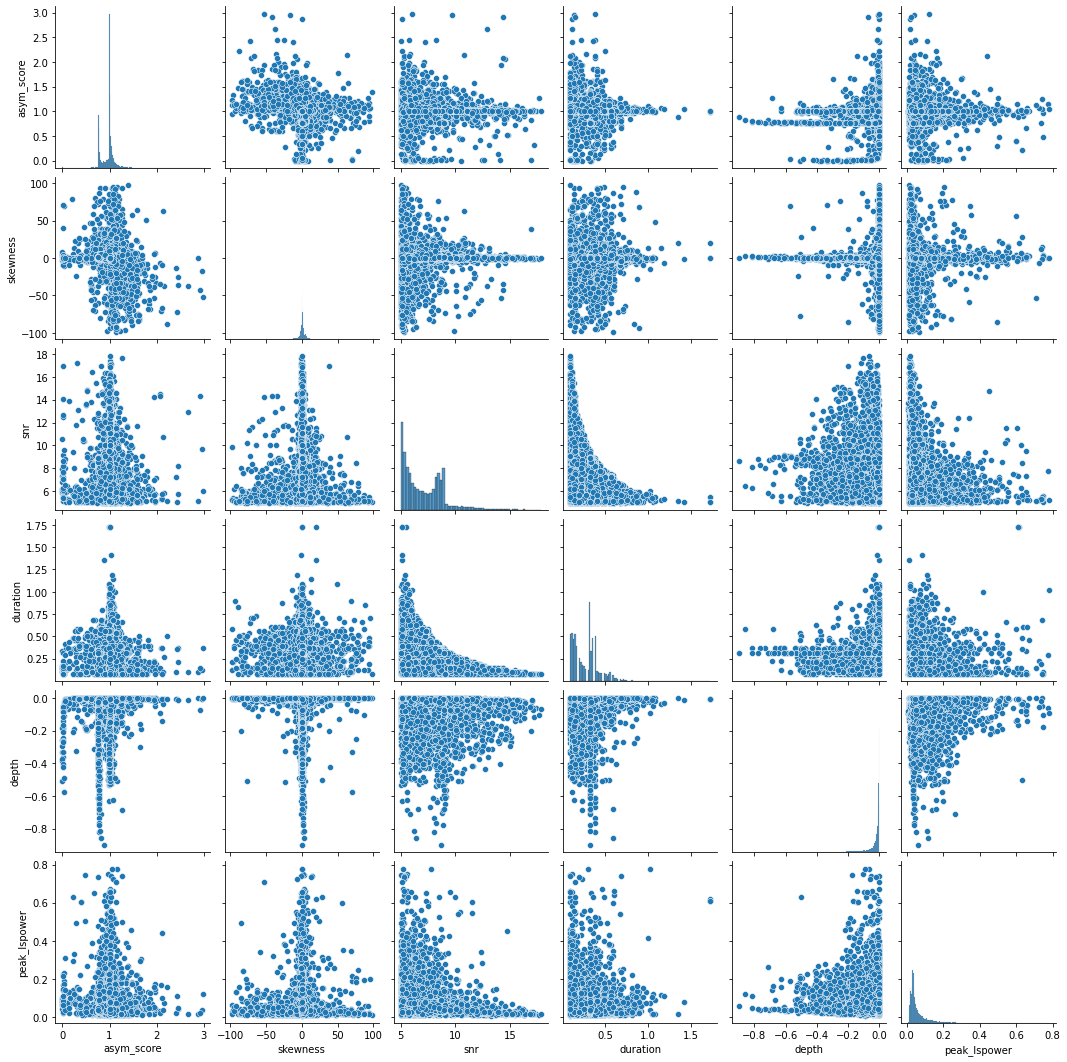

In [25]:
sns.pairplot(data_new,vars=['asym_score','skewness','snr','duration','depth','peak_lspower'])

#### Some variable comparisons

(array([[1.079e+04, 3.990e+02, 2.080e+02, 1.140e+02, 6.300e+01, 2.500e+01,
         1.200e+01, 5.000e+00, 3.000e+00, 2.000e+00],
        [1.330e+03, 2.200e+02, 9.500e+01, 5.300e+01, 4.000e+01, 1.700e+01,
         2.000e+00, 2.000e+00, 0.000e+00, 2.000e+00],
        [3.620e+02, 8.800e+01, 2.400e+01, 1.600e+01, 1.100e+01, 7.000e+00,
         1.000e+00, 2.000e+00, 0.000e+00, 0.000e+00],
        [1.220e+02, 2.500e+01, 1.000e+01, 4.000e+00, 2.000e+00, 0.000e+00,
         0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00],
        [5.600e+01, 6.000e+00, 4.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [1.900e+01, 1.200e+01, 3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [1.300e+01, 3.000e+00, 3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [1.000e+01, 4.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.

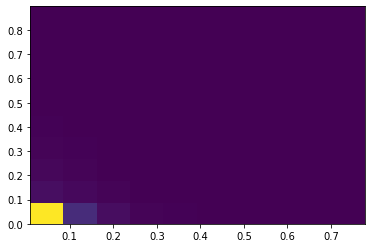

In [26]:
plt.hist2d(data_new.peak_lspower, abs(data_new.depth))

Text(0, 0.5, 'depth')

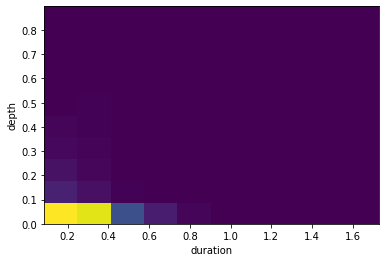

In [27]:
plt.hist2d(data_new.duration, abs(data_new.depth))
plt.xlabel('duration')
plt.ylabel('depth')

Text(0, 0.5, 'depth')

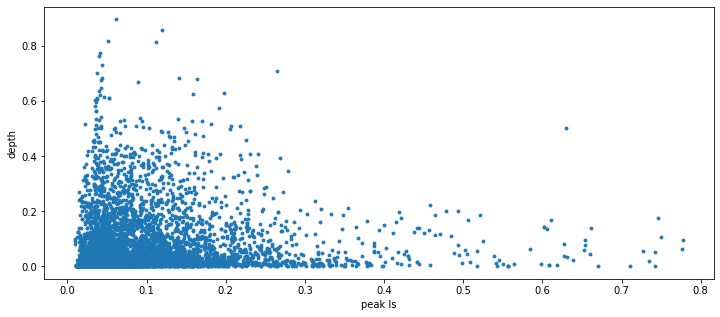

In [28]:
plt.figure(figsize=(12,5))
plt.scatter(data_new.peak_lspower,abs(data_new.depth),s=8)
plt.xlabel('peak ls')
plt.ylabel('depth')

Text(0, 0.5, 'depth')

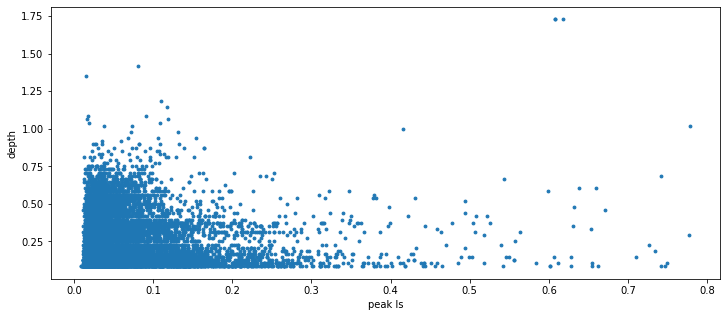

In [29]:
plt.figure(figsize=(12,5))
plt.scatter(data_new.peak_lspower,abs(data_new.duration),s=8)
plt.xlabel('peak ls')
plt.ylabel('depth')

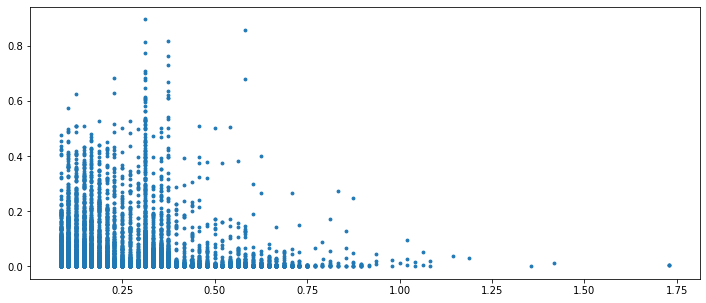

In [30]:
plt.figure(figsize=(12,5))
plt.scatter(data_new.duration,abs(data_new.depth),s=8)

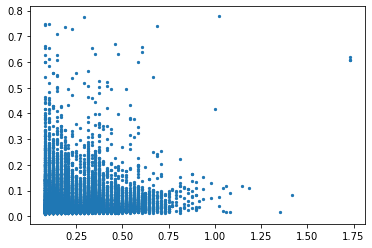

In [31]:
plt.scatter(data_new.duration,abs(data_new.peak_lspower),s=5)

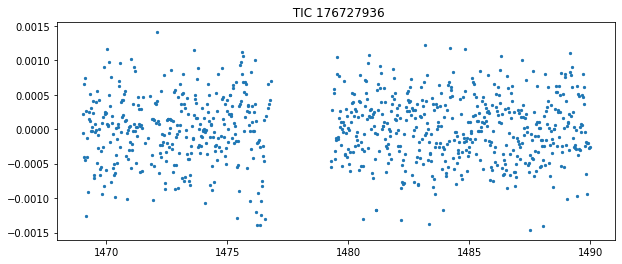

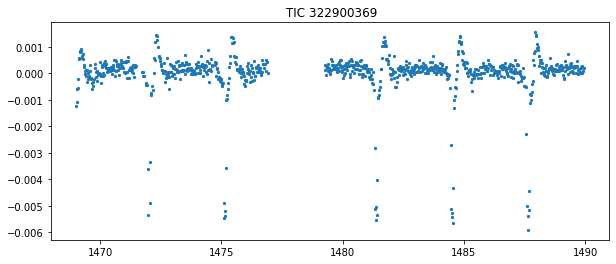

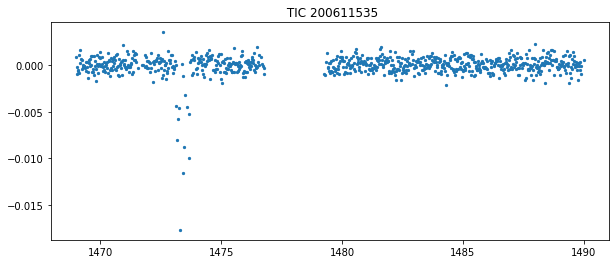

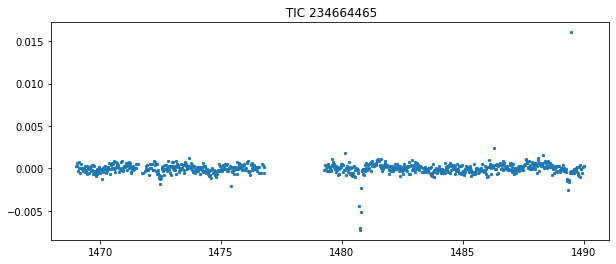

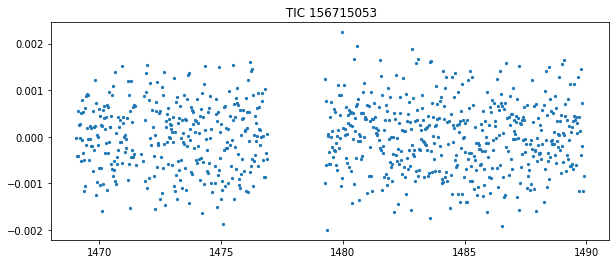

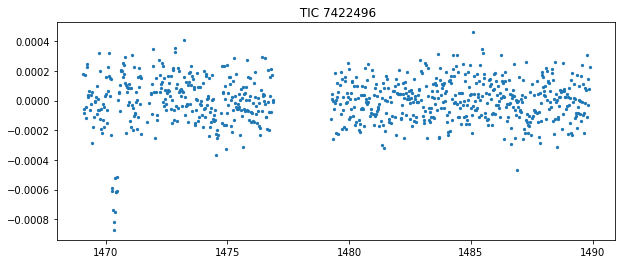

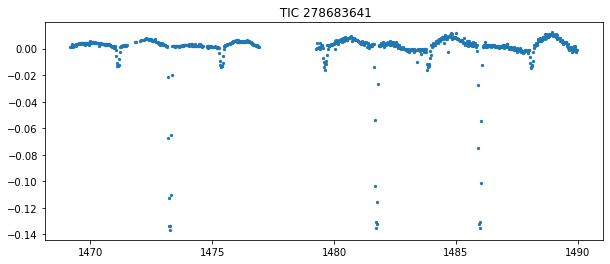

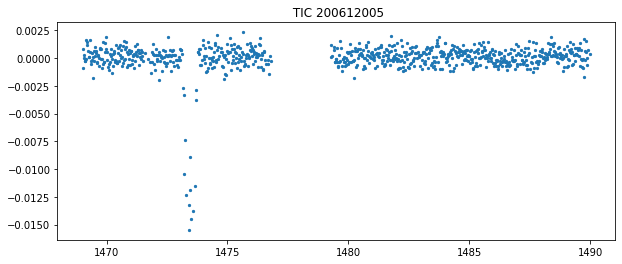

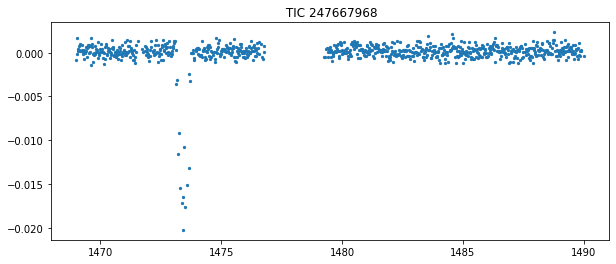

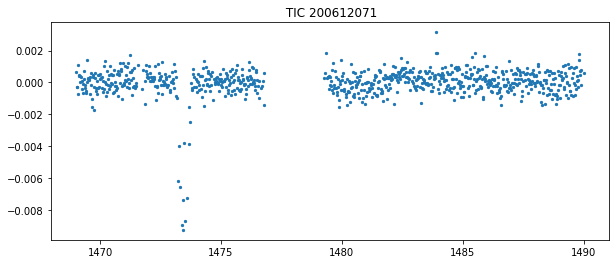

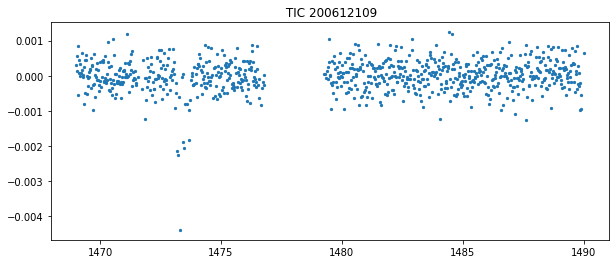

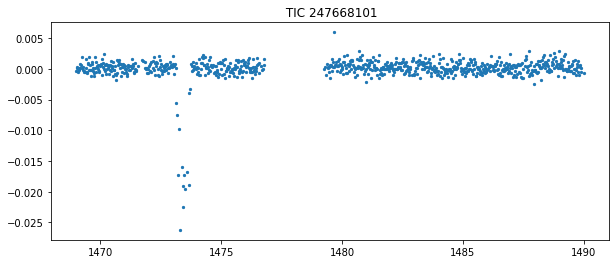

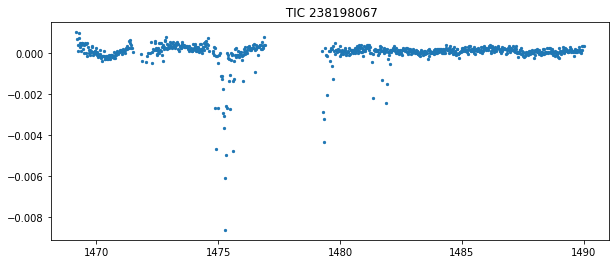

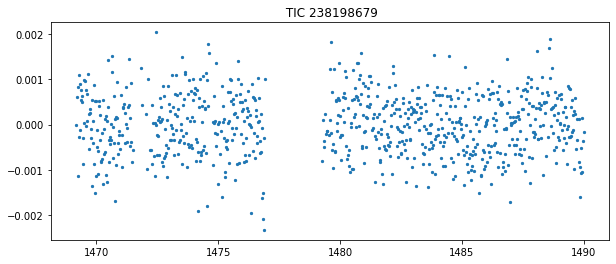

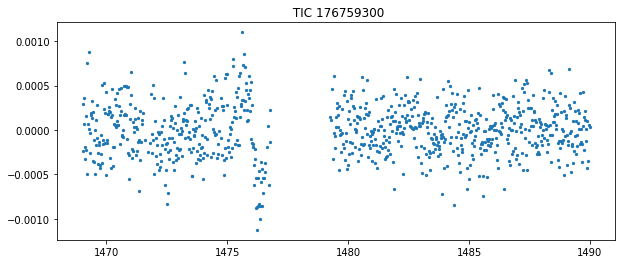

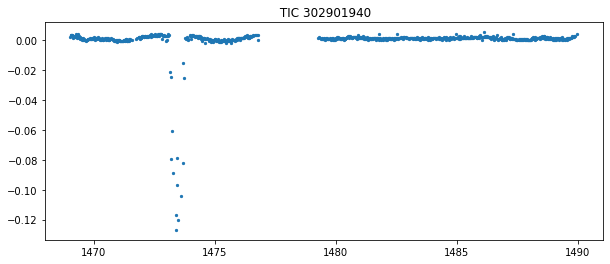

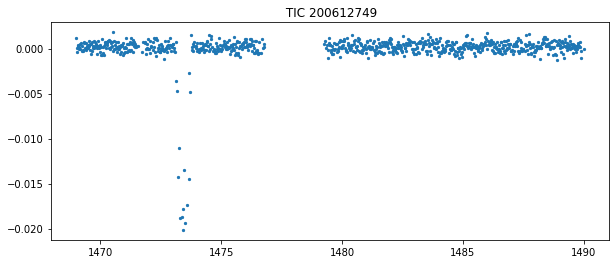

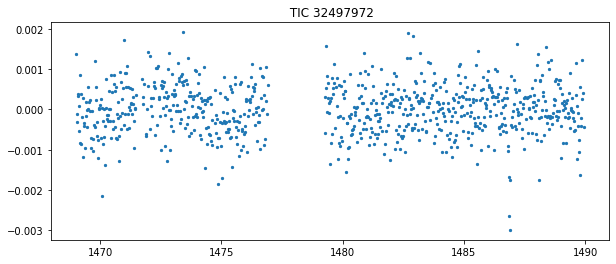

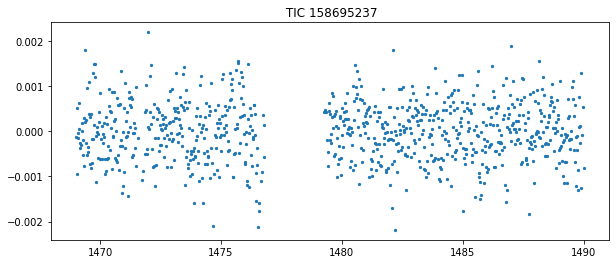

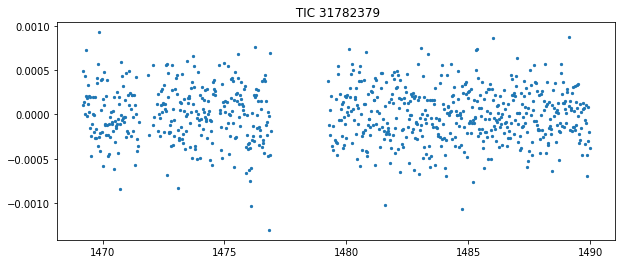

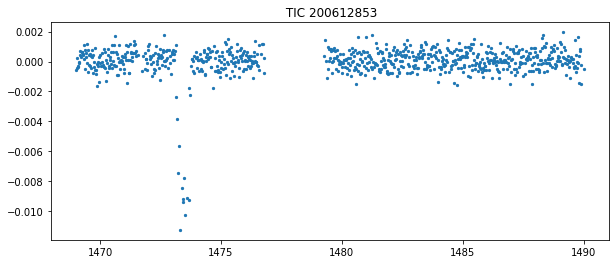

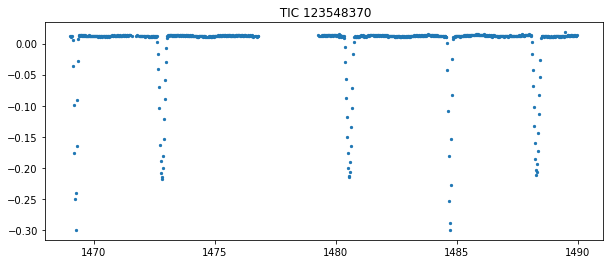

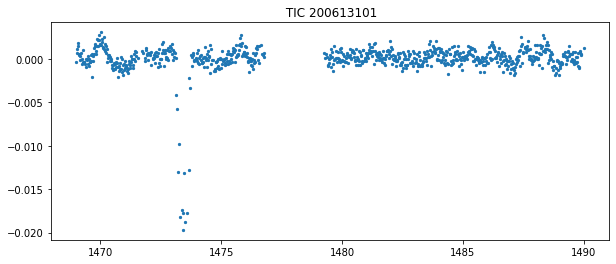

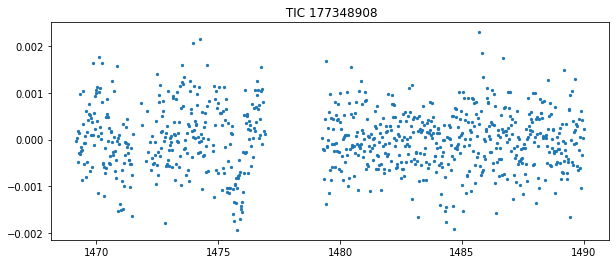

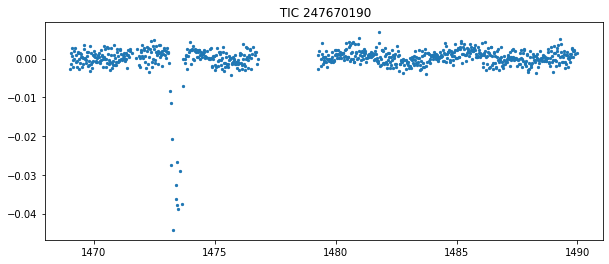

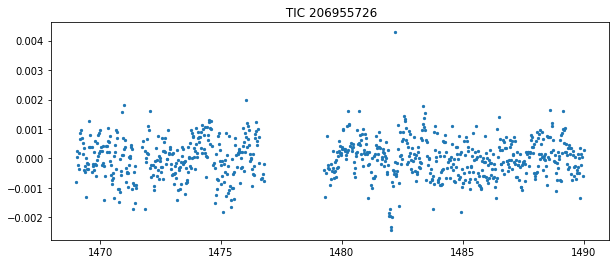

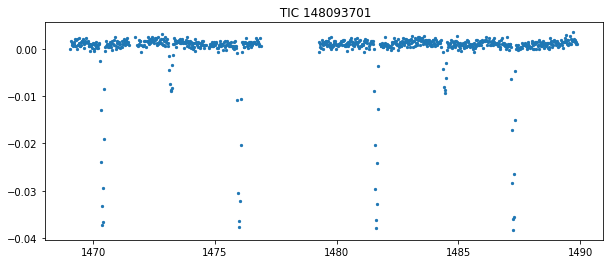

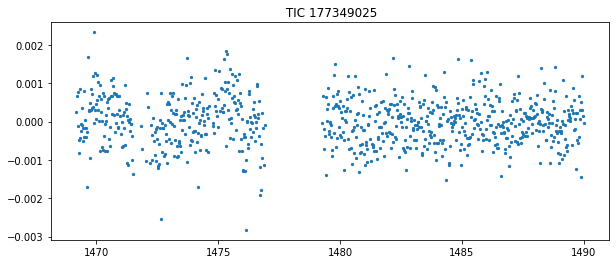

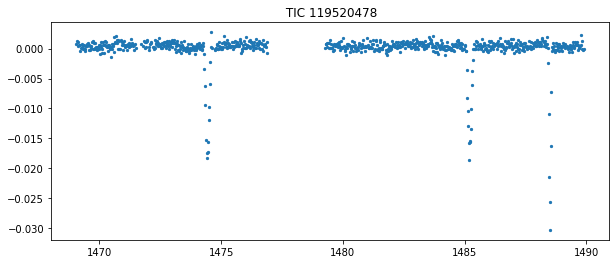

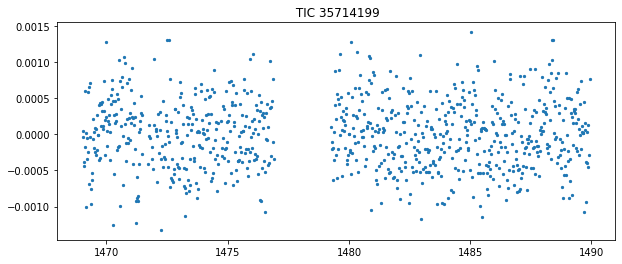

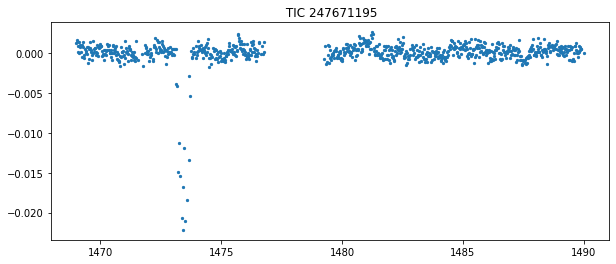

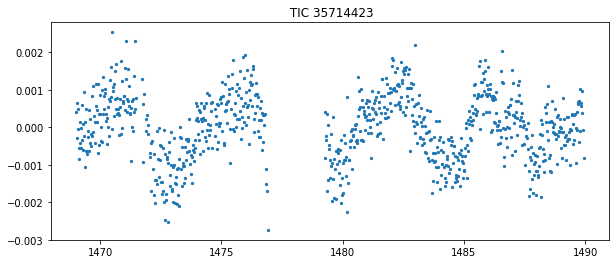

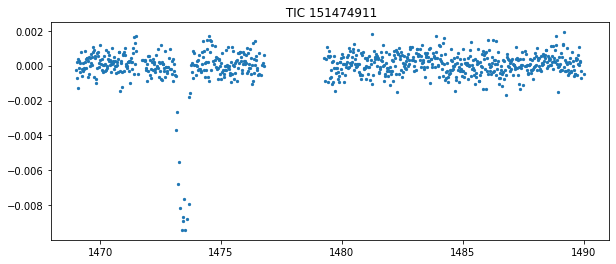

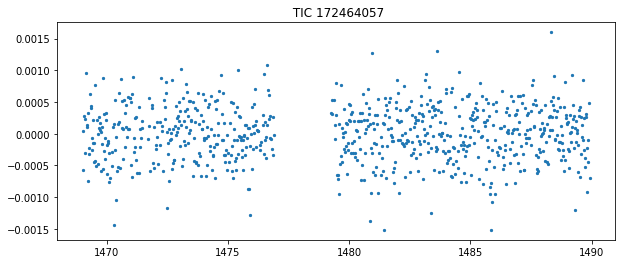

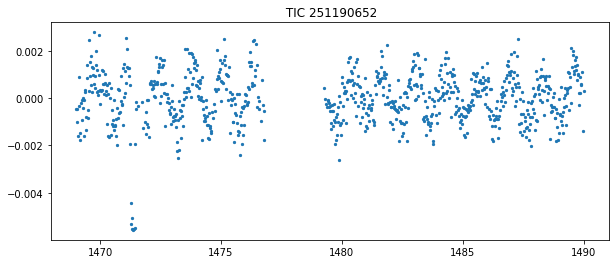

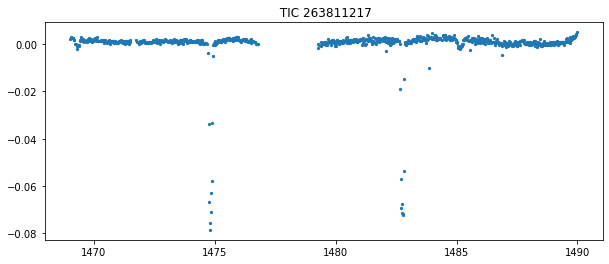

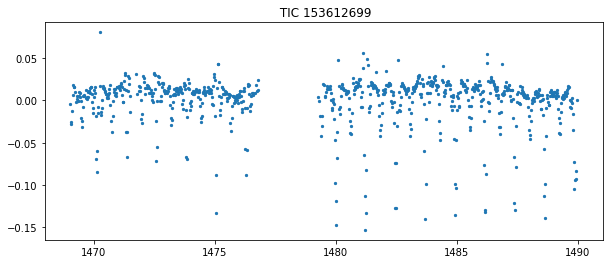

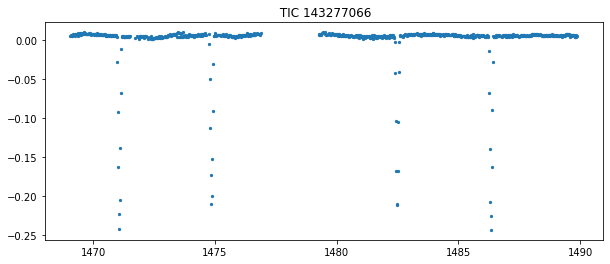

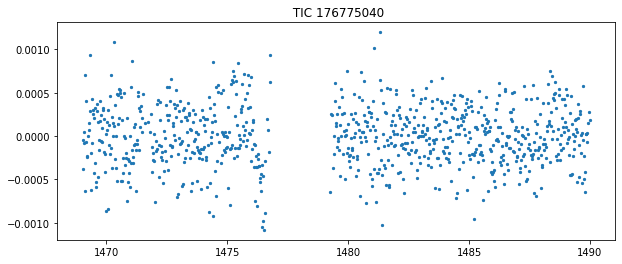

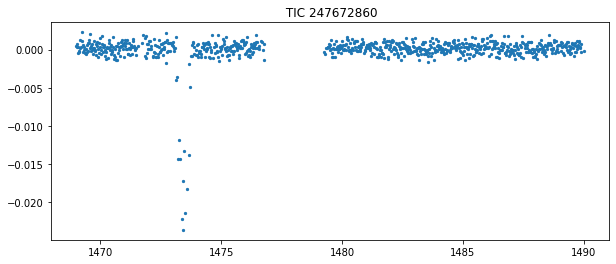

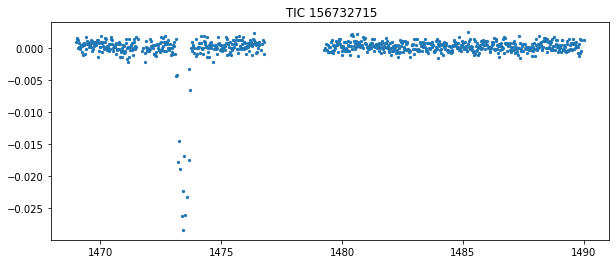

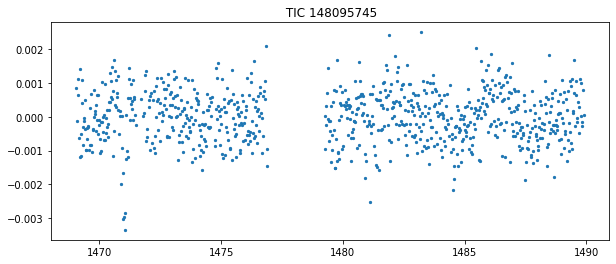

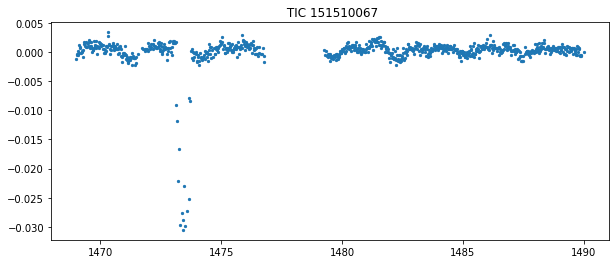

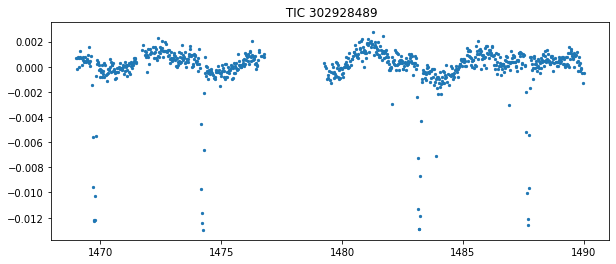

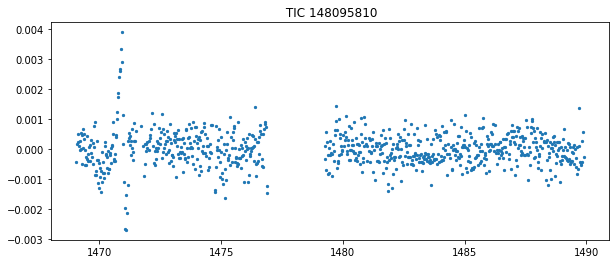

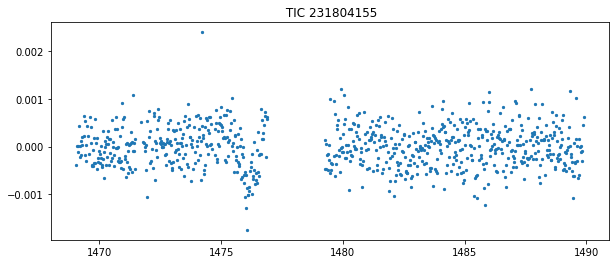

In [32]:
for i in data_new.path.head(50)[data_new.duration <= 0.5]: #4 x 4 grid for illustration purposes
    lc, lc_info = import_XRPlightcurve(i,sector=6)
    plt.figure(figsize=(10,4))
    plt.scatter(lc['time'],normalise_flux(lc['corrected flux']), s=5)
    plt.title(f' TIC {lc_info[0]}')
    plt.show()

---
### Deleting `.npz` files that do not exist in the above pairplot

In [33]:
data_new.head()
len(data_new)

14210

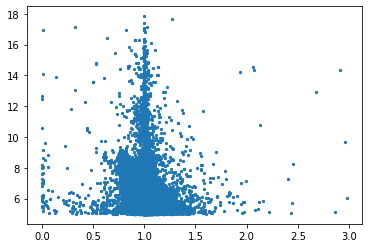

In [34]:
plt.scatter(data_new.asym_score,abs(data_new.snr),s=5)

In [35]:
#data_new[data_new.asym_score <= 0.5].path[301]

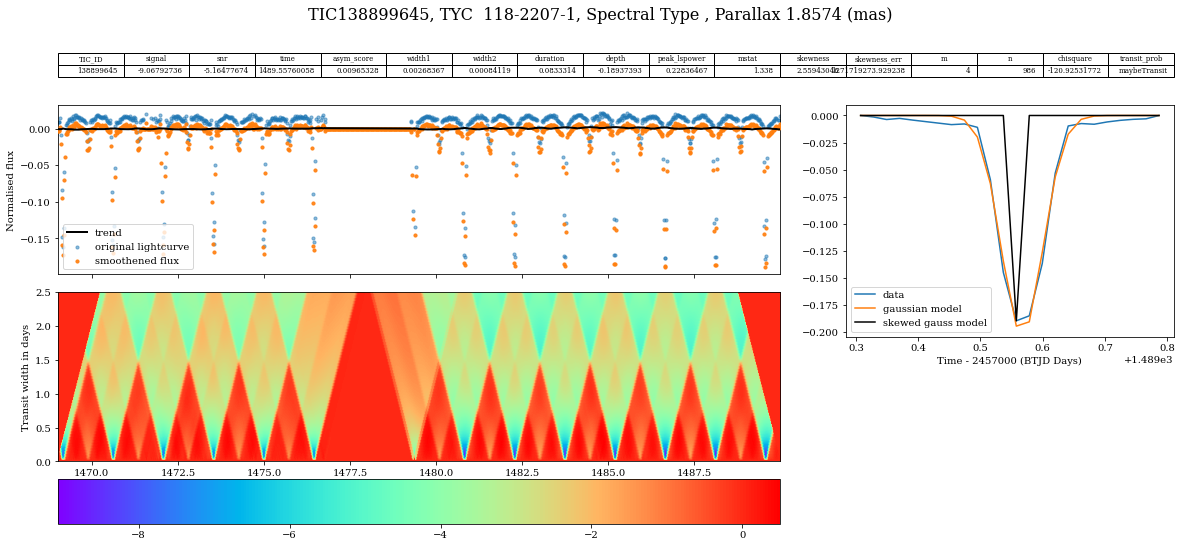

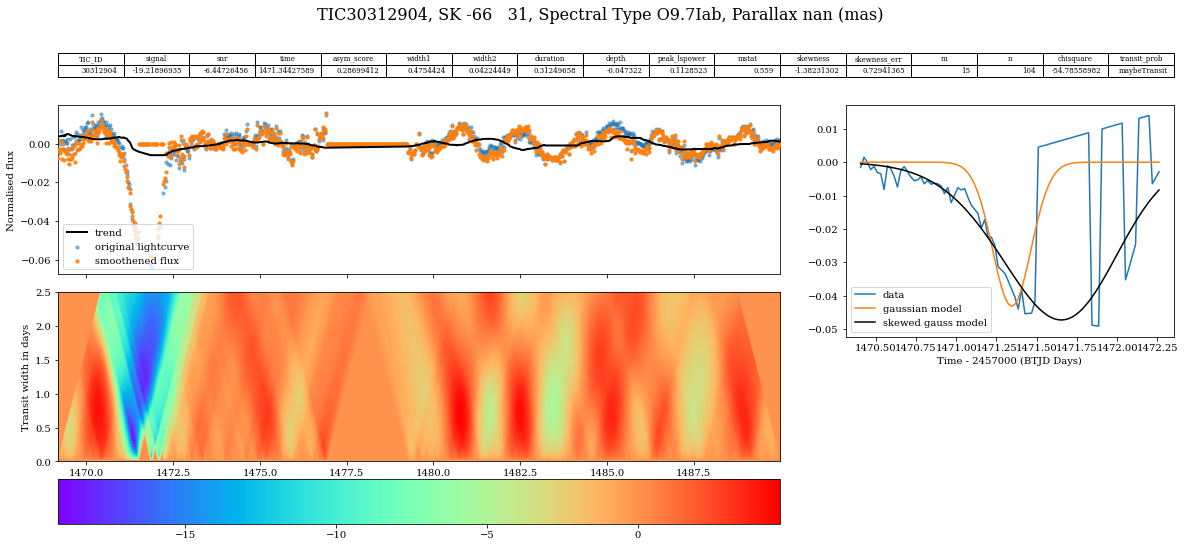

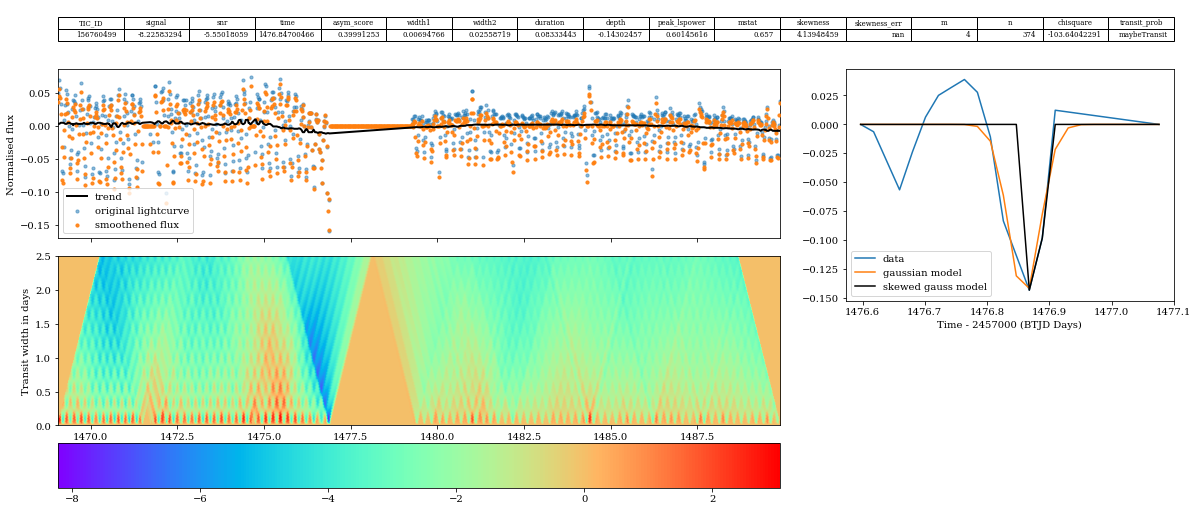

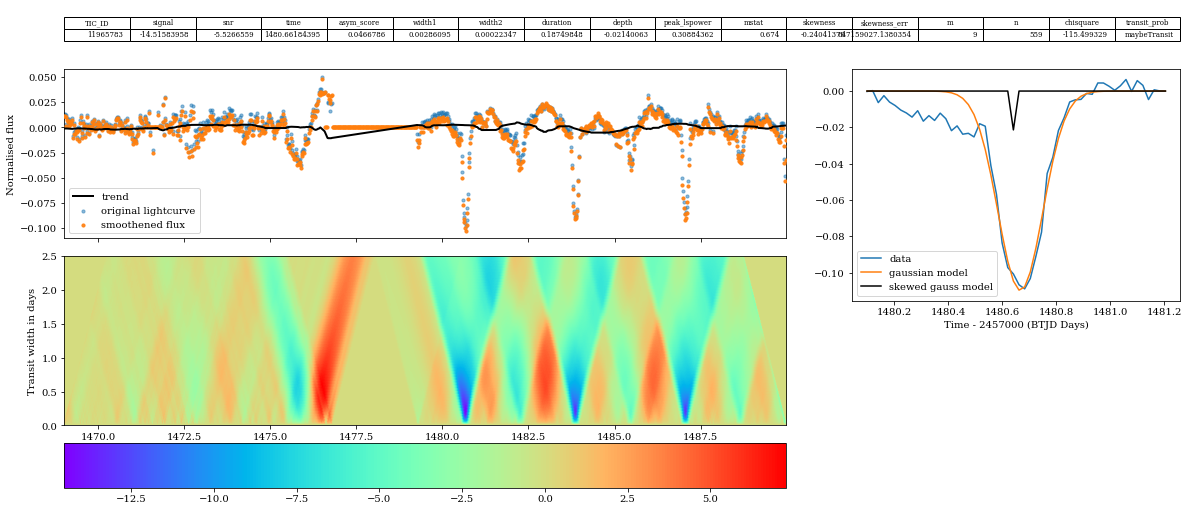

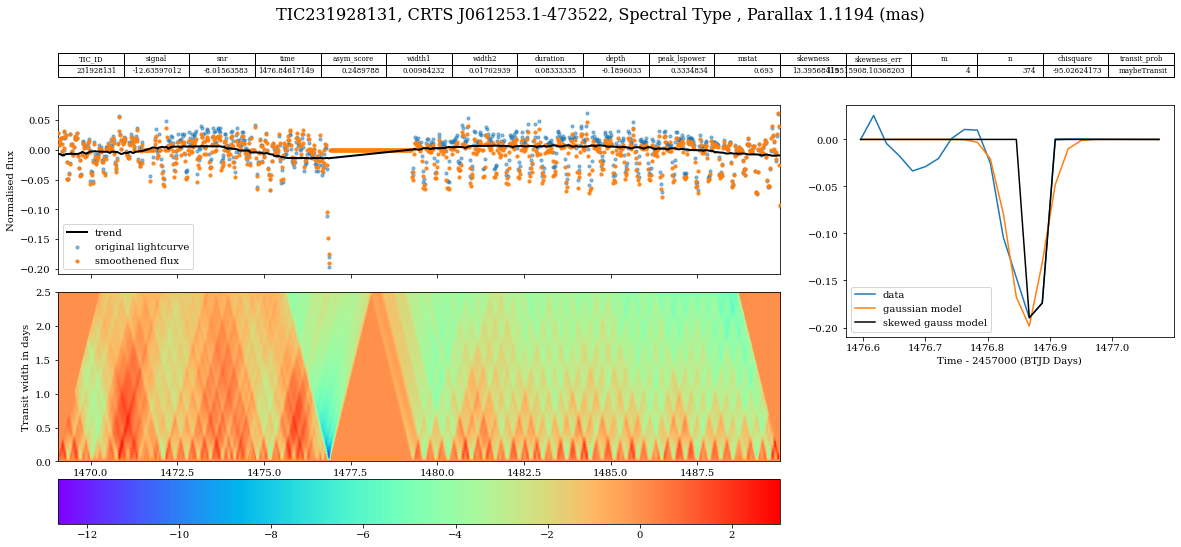

In [36]:
for i in data_new[data_new.asym_score <= 0.5].path.head():
    lc, lc_info = import_XRPlightcurve(i,sector=6)
    lc = lc['time','corrected flux','quality','flux error']
    results, _ = processing(lc,lc_info=lc_info,method='median', make_plots=True)
#     plt.scatter(lc['time'],normalise_flux(lc['corrected flux']),s=2)
#     plt.title(f'{lc_info[0]}')
#     plt.show()

### Producing SOM cutouts of only specific candidates

In [ ]:
for i in data_new.path:
    lc, lc_info = import_XRPlightcurve(i,sector=6)
    lc = lc['time','corrected flux','quality','flux error']
    results, _ = processing(lc,lc_info=lc_info,method='median',som_cutouts=True)
    #plt.scatter(data['TIME'],data['PDCSAP_FLUX'],s=2)


In [ ]:
#data.path[~data.path.isin(data_new.path) == True].to_csv('paths.csv')